In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import pycountry
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from focal_loss import BinaryFocalLoss
from sklearn.metrics import recall_score, precision_score
from tensorflow.keras import metrics
from sklearn.utils.class_weight import compute_sample_weight


## Load Data

In [30]:
dfolder = '../data/'

In [31]:
df_final = pd.read_csv(dfolder + 'preprocessed_df.csv')

## Preprocessing

In [32]:
df_final['country'] = df_final['Country Name']

In [33]:
df_final['armedconf'] = df_final['armedconf'].astype(int)
df_final['civilwar'] = df_final['civilwar'].astype(int)
df_final = df_final[df_final['year'] >= 2000]


## Normalizing

Here i'm taking the top 10 countries for model intereprestability later

In [34]:
armedconfdf = df_final.drop(columns=['civilwar','Country Name', 'MonthYear', 'date', 'state_deaths','nonstate_deaths','onesided_deaths','civilian_deaths'])

In [35]:
armedconfdf.columns

Index(['isocode', 'month', 'year', 'deaths', 'month_year', 'wb_pop',
       'total_events', 'total_events_gov', 'total_events_opp',
       'share_events_count_events_1',
       ...
       'past6', 'past12', 'past60', 'past120', 'armedconf_since',
       'num_regions', 'Adm1_Max', 'Adm1_Mean', 'Adm1_Median', 'country'],
      dtype='object', length=103)

In [36]:
top_10_countries=pd.DataFrame(armedconfdf.groupby('country')['armedconf'].sum()).sort_values(by='armedconf',ascending=False).reset_index()
top_10_country_names=top_10_countries.country[:11]

In [37]:
# normalized the data 
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df_final.drop(columns=['isocode','month','year','civilwar','armedconf','Country Name', 'MonthYear', 'month_year', 'date', 'country']))

In [38]:
scaled_df=pd.DataFrame(data=scaled,columns=df_final.drop(columns=['isocode','month','year','civilwar','armedconf','Country Name', 'MonthYear', 'month_year', 'date', 'country']).columns)


In [39]:
scaled_df

,deaths,state_deaths,nonstate_deaths,onesided_deaths,civilian_deaths,wb_pop,total_events,total_events_gov,total_events_opp,share_events_count_events_1,...,deaths_state_pc,past6,past12,past60,past120,armedconf_since,num_regions,Adm1_Max,Adm1_Mean,Adm1_Median
0,0.002054,0.002117,0.0,0.000000,0.001888,0.013818,0.001234,0.001357,0.001280,0.114855,...,0.004603,0.088991,0.031529,0.146054,0.042366,0.000000,0.133047,0.241271,0.304625,0.316220
1,0.001370,0.000000,0.0,0.012312,0.002614,0.011588,0.001280,0.001977,0.002246,0.131365,...,0.003658,0.031879,0.023356,0.022099,0.022688,0.000000,0.081545,0.072586,0.066002,0.070612
2,0.000000,0.000000,0.0,0.000000,0.000000,0.002168,0.001282,0.001844,0.001721,0.108656,...,0.000000,0.000000,0.000265,0.000156,0.000024,0.021792,0.055794,0.000023,0.000021,0.000020
3,0.000000,0.000000,0.0,0.000000,0.000000,0.002299,0.000231,0.000314,0.000126,0.110429,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.322034,0.030043,0.000005,0.000004,0.000004
4,0.000000,0.000000,0.0,0.000000,0.000000,0.026228,0.000579,0.001005,0.000567,0.118174,...,0.000000,0.000000,0.000000,0.000000,0.000030,0.159806,0.077253,0.000589,0.000155,0.000068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54742,0.000000,0.000000,0.0,0.000000,0.000000,0.001245,0.000153,0.000177,0.000063,0.092308,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.997579,0.038627,0.000000,0.000000,0.000000
54743,0.000000,0.000000,0.0,0.000000,0.000000,0.023333,0.000793,0.000970,0.000987,0.082192,...,0.000000,0.004942,0.003316,0.082242,0.019899,0.004843,0.081545,0.076791,0.063539,0.064971
54744,0.000000,0.000000,0.0,0.000000,0.000000,0.042033,0.010216,0.010367,0.002666,0.151882,...,0.000000,0.000000,0.000014,0.000083,0.000013,0.053269,0.042918,0.005656,0.006331,0.007530
54745,0.000000,0.000000,0.0,0.000000,0.000000,0.013768,0.000620,0.000917,0.000042,0.146992,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.624697,0.042918,0.000046,0.000034,0.000033


In [40]:
conf=df_final.copy()
conf[scaled_df.columns]=np.array(scaled_df)
conf['country']=list(conf.country)
conf=conf.set_index(['isocode','month','year'])
conf

,,,MonthYear,deaths,state_deaths,nonstate_deaths,onesided_deaths,civilian_deaths,month_year,Country Name,wb_pop,date,...,past6,past12,past60,past120,armedconf_since,num_regions,Adm1_Max,Adm1_Mean,Adm1_Median,country
isocode,month,year,,,,,,,,,,,,,,,,,,,,,
AFG,1,2000,1970-01-01 00:00:00.000200001,0.002054,0.002117,0.0,0.000000,0.001888,2000-01-01,Afghanistan,0.013818,2000-01-01,...,0.088991,0.031529,0.146054,0.042366,0.000000,0.133047,0.241271,0.304625,0.316220,Afghanistan
AGO,1,2000,1970-01-01 00:00:00.000200001,0.001370,0.000000,0.0,0.012312,0.002614,2000-01-01,Angola,0.011588,2000-01-01,...,0.031879,0.023356,0.022099,0.022688,0.000000,0.081545,0.072586,0.066002,0.070612,Angola
ALB,1,2000,1970-01-01 00:00:00.000200001,0.000000,0.000000,0.0,0.000000,0.000000,2000-01-01,Albania,0.002168,2000-01-01,...,0.000000,0.000265,0.000156,0.000024,0.021792,0.055794,0.000023,0.000021,0.000020,Albania
ARE,1,2000,1970-01-01 00:00:00.000200001,0.000000,0.000000,0.0,0.000000,0.000000,2000-01-01,United Arab Emirates,0.002299,2000-01-01,...,0.000000,0.000000,0.000000,0.000000,0.322034,0.030043,0.000005,0.000004,0.000004,United Arab Emirates
ARG,1,2000,1970-01-01 00:00:00.000200001,0.000000,0.000000,0.0,0.000000,0.000000,2000-01-01,Argentina,0.026228,2000-01-01,...,0.000000,0.000000,0.000000,0.000030,0.159806,0.077253,0.000589,0.000155,0.000068,Argentina
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XKX,5,2023,1970-01-01 00:00:00.000202305,0.000000,0.000000,0.0,0.000000,0.000000,2023-05-01,Kosovo,0.001245,2023-05-01,...,0.000000,0.000000,0.000000,0.000000,0.997579,0.038627,0.000000,0.000000,0.000000,Kosovo
YEM,5,2023,1970-01-01 00:00:00.000202305,0.000000,0.000000,0.0,0.000000,0.000000,2023-05-01,"Yemen, Rep.",0.023333,2023-05-01,...,0.004942,0.003316,0.082242,0.019899,0.004843,0.081545,0.076791,0.063539,0.064971,"Yemen, Rep."
ZAF,5,2023,1970-01-01 00:00:00.000202305,0.000000,0.000000,0.0,0.000000,0.000000,2023-05-01,South Africa,0.042033,2023-05-01,...,0.000000,0.000014,0.000083,0.000013,0.053269,0.042918,0.005656,0.006331,0.007530,South Africa


In [41]:
top_10_country_names

0                  Afghanistan
1                      Somalia
2                         Iraq
3                        Sudan
4             Congo, Dem. Rep.
5     Central African Republic
6                      Nigeria
7                       Israel
8                  Yemen, Rep.
9         Syrian Arab Republic
10                      Mexico
Name: country, dtype: object

In [42]:
conf.drop(['civilwar', 'Country Name', 'MonthYear', 'month_year', 'date', 'state_deaths','nonstate_deaths','onesided_deaths','civilian_deaths'], axis=1, inplace=True)


In [43]:
conf

,,,deaths,wb_pop,total_events,total_events_gov,total_events_opp,share_events_count_events_1,share_events_count_events_2,share_events_count_events_3,share_events_count_events_4,share_events_count_events_5,...,past6,past12,past60,past120,armedconf_since,num_regions,Adm1_Max,Adm1_Mean,Adm1_Median,country
isocode,month,year,,,,,,,,,,,,,,,,,,,,,
AFG,1,2000,0.002054,0.013818,0.001234,0.001357,0.001280,0.114855,0.045559,0.072741,0.346861,0.089969,...,0.088991,0.031529,0.146054,0.042366,0.000000,0.133047,0.241271,0.304625,0.316220,Afghanistan
AGO,1,2000,0.001370,0.011588,0.001280,0.001977,0.002246,0.131365,0.042804,0.085240,0.254982,0.052768,...,0.031879,0.023356,0.022099,0.022688,0.000000,0.081545,0.072586,0.066002,0.070612,Angola
ALB,1,2000,0.000000,0.002168,0.001282,0.001844,0.001721,0.108656,0.046041,0.081400,0.275875,0.060037,...,0.000000,0.000265,0.000156,0.000024,0.021792,0.055794,0.000023,0.000021,0.000020,Albania
ARE,1,2000,0.000000,0.002299,0.000231,0.000314,0.000126,0.110429,0.026585,0.065440,0.533742,0.051125,...,0.000000,0.000000,0.000000,0.000000,0.322034,0.030043,0.000005,0.000004,0.000004,United Arab Emirates
ARG,1,2000,0.000000,0.026228,0.000579,0.001005,0.000567,0.118174,0.053790,0.114914,0.418093,0.060310,...,0.000000,0.000000,0.000000,0.000030,0.159806,0.077253,0.000589,0.000155,0.000068,Argentina
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XKX,5,2023,0.000000,0.001245,0.000153,0.000177,0.000063,0.092308,0.076923,0.089231,0.307692,0.190769,...,0.000000,0.000000,0.000000,0.000000,0.997579,0.038627,0.000000,0.000000,0.000000,Kosovo
YEM,5,2023,0.000000,0.023333,0.000793,0.000970,0.000987,0.082192,0.046456,0.054199,0.406194,0.107802,...,0.004942,0.003316,0.082242,0.019899,0.004843,0.081545,0.076791,0.063539,0.064971,"Yemen, Rep."
ZAF,5,2023,0.000000,0.042033,0.010216,0.010367,0.002666,0.151882,0.068819,0.066460,0.250162,0.075432,...,0.000000,0.000014,0.000083,0.000013,0.053269,0.042918,0.005656,0.006331,0.007530,South Africa


### Train Test Split

In [44]:
def train_test_split_year(data, year):
    # separate train data as all rows before the given year
    x_train = data[data.index.get_level_values('year') < year].drop(columns=['armedconf'])
    y_train = data[data.index.get_level_values('year') < year]['armedconf']

    # separate test data as all rows from the given year and onwards
    x_test = data[data.index.get_level_values('year') >= year].drop(columns=['armedconf'])
    y_test = data[data.index.get_level_values('year') >= year]['armedconf']

    return x_train, x_test, y_train, y_test

In [45]:
country=list(set(conf.country))
# loop each station and collect train and test data 
X_train=[]
X_test=[]
Y_train=[]
Y_test=[]
for i in range(0,len(country)):
    data=conf[conf['country']==country[i]]
    x_train, x_test,y_train,y_test=train_test_split_year(data, 2018)
    X_train.append(x_train)
    X_test.append(x_test)
    Y_train.append(y_train)
    Y_test.append(y_test)

In [46]:
# concat each train data from each station 
X_train=pd.concat(X_train)
Y_train=pd.DataFrame(pd.concat(Y_train))
# concat each test data from each station º
X_test=pd.concat(X_test)
Y_test=pd.DataFrame(pd.concat(Y_test))

In [47]:
X_train

deaths    wb_pop  total_events  total_events_gov  \
isocode month year                                                     
GNQ     1     2000     0.0  0.000465      0.000010          0.000017   
        2     2000     0.0  0.000465      0.000015          0.000019   
        3     2000     0.0  0.000465      0.000013          0.000014   
        4     2000     0.0  0.000465      0.000024          0.000036   
        5     2000     0.0  0.000465      0.000029          0.000037   
...                    ...       ...           ...               ...   
SUR     8     2017     0.0  0.000396      0.000119          0.000141   
        9     2017     0.0  0.000396      0.000104          0.000143   
        10    2017     0.0  0.000396      0.000125          0.000165   
        11    2017     0.0  0.000396      0.000177          0.000170   
        12    2017     0.0  0.000396      0.000205          0.000133   

                    total_events_opp  share_events_count_events_1  \
isocode month year                                                  
GNQ     1     2000          0.000000                     0.000000   
        2     2000          0.000021                     0.031250   
        3     2000          0.000042                     0.214286   
        4     2000          0.000000                     0.115385   
        5     2000          0.000042                     0.177419   
...                              ...                          ...   
SUR     8     2017          0.000000                     0.194444   
        9     2017          0.000000                     0.203620   
        10    2017          0.000021                     0.109434   
        11    2017          0.000084                     0.128000   
        12    2017          0.000000                     0.041475   

                    share_events_count_events_2  share_events_count_events_3  \
isocode month year                                                             
GNQ     1     2000                     0.000000                     0.000000   
        2     2000                     0.093750                     0.031250   
        3     2000                     0.000000                     0.071429   
        4     2000                     0.000000                     0.000000   
        5     2000                     0.016129                     0.145161   
...                                         ...                          ...   
SUR     8     2017                     0.067460                     0.039683   
        9     2017                     0.045249                     0.076923   
        10    2017                     0.037736                     0.169811   
        11    2017                     0.048000                     0.093333   
        12    2017                     0.018433                     0.055300   

                    share_events_count_events_4  share_events_count_events_5  \
isocode month year                                                             
GNQ     1     2000                     0.000000                     0.000000   
        2     2000                     0.531250                     0.062500   
        3     2000                     0.142857                     0.000000   
        4     2000                     0.538462                     0.038462   
        5     2000                     0.387097                     0.096774   
...                                         ...                          ...   
SUR     8     2017                     0.257937                     0.107143   
        9     2017                     0.361991                     0.117647   
        10    2017                     0.339623                     0.139623   
        11    2017                     0.458667                     0.093333   
        12    2017                     0.410138                     0.304147   

                    ...  past6  past12  past60  past120  armedconf_since  \
isocode month year  ...    

In [48]:
X_test

deaths    wb_pop  total_events  total_events_gov  \
isocode month year                                                     
GNQ     1     2018     0.0  0.001044      0.000588          0.000948   
        2     2018     0.0  0.001044      0.000411          0.000489   
        3     2018     0.0  0.001044      0.000305          0.000395   
        4     2018     0.0  0.001044      0.000389          0.000687   
        5     2018     0.0  0.001044      0.000353          0.000467   
...                    ...       ...           ...               ...   
SUR     1     2023     0.0  0.000414      0.000280          0.000688   
        2     2023     0.0  0.000414      0.000097          0.000143   
        3     2023     0.0  0.000414      0.000095          0.000150   
        4     2023     0.0  0.000414      0.000160          0.000164   
        5     2023     0.0  0.000414      0.000072          0.000090   

                    total_events_opp  share_events_count_events_1  \
isocode month year                                                  
GNQ     1     2018          0.000630                     0.186998   
        2     2018          0.000441                     0.113793   
        3     2018          0.000147                     0.108359   
        4     2018          0.000168                     0.081311   
        5     2018          0.000084                     0.154873   
...                              ...                          ...   
SUR     1     2023          0.000021                     0.090909   
        2     2023          0.000063                     0.106796   
        3     2023          0.000126                     0.109453   
        4     2023          0.000021                     0.079646   
        5     2023          0.000000                     0.097403   

                    share_events_count_events_2  share_events_count_events_3  \
isocode month year                                                             
GNQ     1     2018                     0.033708                     0.055377   
        2     2018                     0.101149                     0.078161   
        3     2018                     0.063467                     0.095975   
        4     2018                     0.069175                     0.087379   
        5     2018                     0.101469                     0.084112   
...                                         ...                          ...   
SUR     1     2023                     0.045455                     0.089226   
        2     2023                     0.092233                     0.077670   
        3     2023                     0.139303                     0.049751   
        4     2023                     0.073746                     0.041298   
        5     2023                     0.071429                     0.123377   

                    share_events_count_events_4  share_events_count_events_5  \
isocode month year                                                             
GNQ     1     2018                     0.235955                     0.108347   
        2     2018                     0.248276                     0.103448   
        3     2018                     0.185759                     0.068111   
        4     2018                     0.433252                     0.144417   
        5     2018                     0.218959                     0.133511   
...                                         ...                          ...   
SUR     1     2023                     0.483165                     0.109428   
        2     2023                     0.237864                     0.072816   
        3     2023                     0.303483                     0.069652   
        4     2023                     0.492625                     0.041298   
        5     2023                     0.298701                     0.123377   

                    ...  past6  past12  past60  past120  armedconf_since  \
isocode month year  ...    

## Model

In [49]:
def series_to_supervised(data, target_column_index, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        target_column_index: The index of the target column in data
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t)
    for i in range(n_in, -1, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t+1)
    cols.append(df[df.columns[target_column_index]].shift(-n_out))
    names += ['var%d(t+%d)' % (target_column_index+1, n_out)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


# create the reshape function
def reshape_data(train,test):
    target_column_index_train = train.shape[1] - 1
    target_column_index_test = test.shape[1] - 1
    #Frame as supervised learning and drop all time t columns except PM2.5
    reframed_train = series_to_supervised(train, target_column_index_train, 1, 1)
    reframed_test = series_to_supervised(test, target_column_index_test, 1, 1)
    reframed_train
    # split into train and test sets
    train= reframed_train.values
    test=reframed_test.values
    # split into input and outputs
    train_X, y_train = train[:, :-1], train[:, -1]
    test_X, y_test = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    x_train = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    x_test = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    return x_train,x_test,y_train, y_test, reframed_train

In [50]:
encoder = LabelEncoder()
#combine x train and y train as train data 
train_data=pd.DataFrame()
train_data[X_train.columns]=X_train
train_data[Y_train.columns]=Y_train
train_data['country']= encoder.fit_transform(train_data['country'])
#combine x test and y test as test data 
test_data=pd.DataFrame()
test_data[X_test.columns]=X_test
test_data[Y_test.columns]=Y_test
test_data['country']= encoder.fit_transform(test_data['country'])
test_data.shape

(12675, 99)

In [52]:
x_train,x_test,y_train,y_test,example =reshape_data(train_data,test_data)

In [53]:
example

var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  \
isocode month year                                                          
GNQ     2     2000        0.0   0.000465   0.000010   0.000017   0.000000   
        3     2000        0.0   0.000465   0.000015   0.000019   0.000021   
        4     2000        0.0   0.000465   0.000013   0.000014   0.000042   
        5     2000        0.0   0.000465   0.000024   0.000036   0.000000   
        6     2000        0.0   0.000465   0.000029   0.000037   0.000042   
...                       ...        ...        ...        ...        ...   
SUR     7     2017        0.0   0.000396   0.000136   0.000205   0.000021   
        8     2017        0.0   0.000396   0.000163   0.000256   0.000126   
        9     2017        0.0   0.000396   0.000119   0.000141   0.000000   
        10    2017        0.0   0.000396   0.000104   0.000143   0.000000   
        11    2017        0.0   0.000396   0.000125   0.000165   0.000021   

                    var6(t-1)  var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  \
isocode month year                                                           
GNQ     2     2000   0.000000   0.000000   0.000000   0.000000    0.000000   
        3     2000   0.031250   0.093750   0.031250   0.531250    0.062500   
        4     2000   0.214286   0.000000   0.071429   0.142857    0.000000   
        5     2000   0.115385   0.000000   0.000000   0.538462    0.038462   
        6     2000   0.177419   0.016129   0.145161   0.387097    0.096774   
...                       ...        ...        ...        ...         ...   
SUR     7     2017   0.148789   0.117647   0.089965   0.221453    0.086505   
        8     2017   0.144509   0.109827   0.020231   0.228324    0.144509   
        9     2017   0.194444   0.067460   0.039683   0.257937    0.107143   
        10    2017   0.203620   0.045249   0.076923   0.361991    0.117647   
        11    2017   0.109434   0.037736   0.169811   0.339623    0.139623   

                    ...  var91(t-0)  var92(t-0)  var93(t-0)  var94(t-0)  \
isocode month year  ...                                                   
GNQ     2     2000  ...         0.0         0.0    0.288136    0.004292   
        3     2000  ...         0.0         0.0    0.290557    0.008584   
        4     2000  ...         0.0         0.0    0.292978    0.004292   
        5     2000  ...         0.0         0.0    0.295400    0.008584   
        6     2000  ...         0.0         0.0    0.297821    0.012876   
...                 ...         ...         ...         ...         ...   
SUR     7     2017  ...         0.0         0.0    0.767554    0.017167   
        8     2017  ...         0.0         0.0    0.769976    0.025751   
        9     2017  ...         0.0         0.0    0.772397    0.017167   
        10    2017  ...         0.0         0.0    0.774818    0.030043   
        11    2017  ...         0.0         0.0    0.777240    0.017167   

                    var95(t-0)  var96(t-0)  var97(t-0)  var98(t-0)  \
isocode month year                                                   
GNQ     2     2000    0.000000    0.000000    0.000000          53   
        3     2000    0.000000    0.000000    0.000000          53   
        4     2000    0.000048    0.000065    0.000068          53   
        5     2000    0.000048    0.000065    0.000068          53   
        6     2000    0.000000    0.000000    0.000000          53   
...                        ...         ...         ...         ...   
SUR     7     2017    0.000000    0.000000    0.000000         166   
        8     2017    0.023389    0.010639    0.000000         166   
        9     2017    0.000048    0.000065    0.000068         166   
        10    2017    0.023396    0.015963    0.016665         166   
        11    2017    0.000000    0.000000    0.000000         166   

                    var99(t-0)  var99(t+1)  
isocode month year                          
GNQ     2     2000        

In [54]:
x_test.shape

(12673, 1, 198)

In [55]:
x_train

array([[[0.00000000e+00, 4.65369240e-04, 1.03951037e-05, ...,
         0.00000000e+00, 5.30000000e+01, 0.00000000e+00]],

       [[0.00000000e+00, 4.65369240e-04, 1.46476461e-05, ...,
         0.00000000e+00, 5.30000000e+01, 0.00000000e+00]],

       [[0.00000000e+00, 4.65369240e-04, 1.27576273e-05, ...,
         6.77289696e-05, 5.30000000e+01, 0.00000000e+00]],

       ...,

       [[0.00000000e+00, 3.96392555e-04, 1.18598683e-04, ...,
         6.77289696e-05, 1.66000000e+02, 0.00000000e+00]],

       [[0.00000000e+00, 3.96392555e-04, 1.03951037e-04, ...,
         1.66646340e-02, 1.66000000e+02, 0.00000000e+00]],

       [[0.00000000e+00, 3.96392555e-04, 1.24741245e-04, ...,
         0.00000000e+00, 1.66000000e+02, 0.00000000e+00]]])

In [56]:
# Compute class weights
class_weights = compute_sample_weight(class_weight='balanced', y=y_train)

class_weights = dict(enumerate(class_weights))

# design network for confirmed cases data 
model = Sequential()
model.add(LSTM(60, input_shape=(x_train.shape[1], x_train.shape[2])))  # Single LSTM layer with 60 neurons
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))  # Output layer

loss = BinaryFocalLoss(gamma=2., pos_weight=3)  # Increase gamma for more focus on hard to classify instances
model.compile(loss=loss, optimizer=Adam(learning_rate=0.001), metrics=['accuracy', metrics.Recall()])

# fit network with class weights for handling imbalance
history = model.fit(x_train, y_train, epochs=30, batch_size=50, class_weight=class_weights, verbose=1, shuffle=False)


Epoch 1/100


2023-06-23 11:07:12.665877: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-23 11:07:12.851457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  5/842 [..............................] - ETA: 12s - loss: 0.0937 - accuracy: 0.6000 - recall_1: 0.0000e+00  

2023-06-23 11:07:13.062934: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


842/842 [==============================] - 11s 12ms/step - loss: 0.0883 - accuracy: 0.8957 - recall_1: 0.0544
Epoch 2/100
842/842 [==============================] - 10s 11ms/step - loss: 0.0722 - accuracy: 0.9067 - recall_1: 0.1784
Epoch 3/100
842/842 [==============================] - 10s 12ms/step - loss: 0.0607 - accuracy: 0.9002 - recall_1: 0.3749
Epoch 4/100
842/842 [==============================] - 9s 11ms/step - loss: 0.0458 - accuracy: 0.9293 - recall_1: 0.6002
Epoch 5/100
842/842 [==============================] - 9s 11ms/step - loss: 0.0409 - accuracy: 0.9388 - recall_1: 0.7140
Epoch 6/100
842/842 [==============================] - 9s 11ms/step - loss: 0.0380 - accuracy: 0.9411 - recall_1: 0.7278
Epoch 7/100
842/842 [==============================] - 9s 11ms/step - loss: 0.0373 - accuracy: 0.9432 - recall_1: 0.7387
Epoch 8/100
842/842 [==============================] - 9s 11ms/step - loss: 0.0367 - accuracy: 0.9444 - recall_1: 0.7543
Epoch 9/100
842/842 [====================

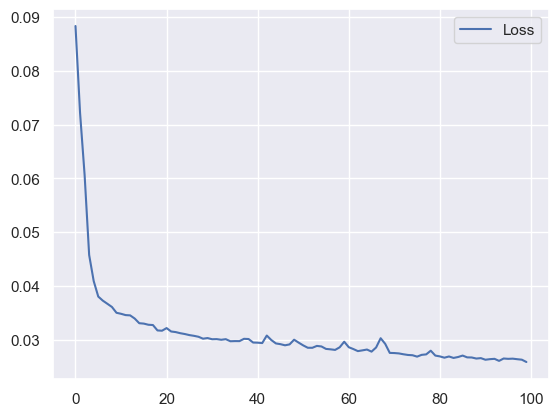

In [57]:
# plot history
plt.plot(history.history['loss'], label='Loss')
plt.legend()
plt.show()

In [58]:
y_hat = model.predict(x_test)

 19/397 [>.............................] - ETA: 1s  

2023-06-23 11:23:10.937106: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-23 11:23:10.995495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


397/397 [==============================] - 1s 3ms/step


In [59]:
y_hat.shape,y_test.shape


((12673, 1), (12673,))

In [60]:
#  y_test prediction has one month lag so we need re-match the date 
len([i[0] for i in y_hat][1:]),len(y_test[:-1])  


(12672, 12672)

In [61]:
y_hat_modified = [i[0] for i in y_hat][2:]  # discarding the first two elements
y_test_modified = y_test[:-2]  # discarding the last two elements

print(len(y_hat_modified), len(y_test_modified))  # check if lengths are now the same

pa = pd.DataFrame()
pa['Month'] = X_test.reset_index().month.iloc[2:-2]  # also adjusted here
pa['Year'] = X_test.reset_index().year.iloc[2:-2]  # and here
pa['Prediction'] = y_hat_modified
pa['Actual Values'] = y_test_modified
pa.head()


12671 12671


,Month,Year,Prediction,Actual Values
2,3,2018,0.050887,0.0
3,4,2018,0.074081,0.0
4,5,2018,0.084086,0.0
5,6,2018,0.131095,0.0
6,7,2018,0.104806,0.0


In [62]:
pa['Actual Values'].sum()

1271.0

## Interpretation

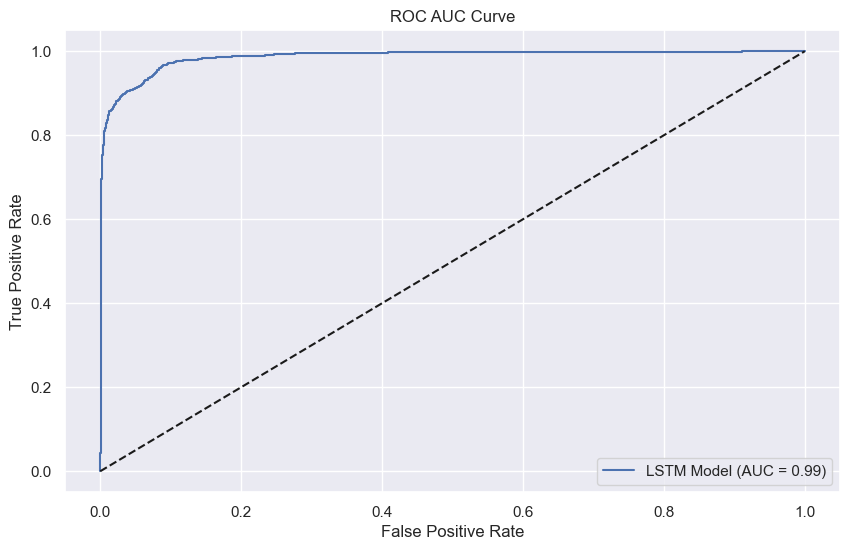

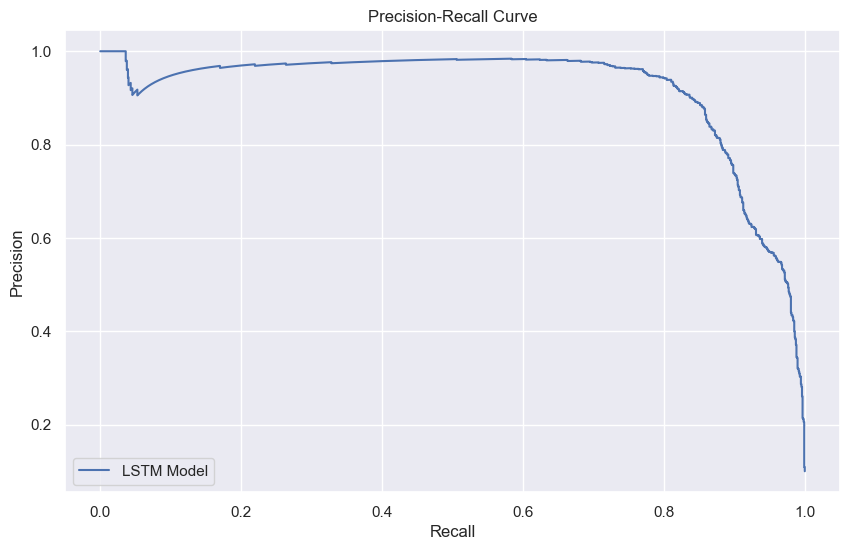

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc


y_true = pa['Actual Values'].values
y_pred = pa['Prediction'].values


# Calculate ROC AUC score
roc_auc = roc_auc_score(y_true, y_pred)

# Calculate Precision and Recall scores
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

# Plot ROC AUC curve
plt.figure(figsize=(10, 6))
plt.plot(*roc_curve(y_true, y_pred)[:2], label='LSTM Model (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label='LSTM Model')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


In [64]:
thresholds

array([9.5265941e-06, 1.1232173e-05, 1.6478318e-05, ..., 9.9998689e-01,
       9.9999428e-01, 9.9999619e-01], dtype=float32)

In [65]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# classes
y_pred_classes = (pa['Prediction'].values > 0.5).astype(int)

print("Confusion Matrix:\n", confusion_matrix(pa['Actual Values'].values, y_pred_classes))

print("\nClassification Report:\n", classification_report(pa['Actual Values'].values, y_pred_classes))

roc_auc_minority = roc_auc_score(pa['Actual Values'].values == 1, y_pred_classes)
print("\nROC AUC for minority class:", roc_auc_minority)

Confusion Matrix:
 [[10742   658]
 [  103  1168]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.94      0.97     11400
         1.0       0.64      0.92      0.75      1271

    accuracy                           0.94     12671
   macro avg       0.82      0.93      0.86     12671
weighted avg       0.96      0.94      0.94     12671


ROC AUC for minority class: 0.9306210747166894


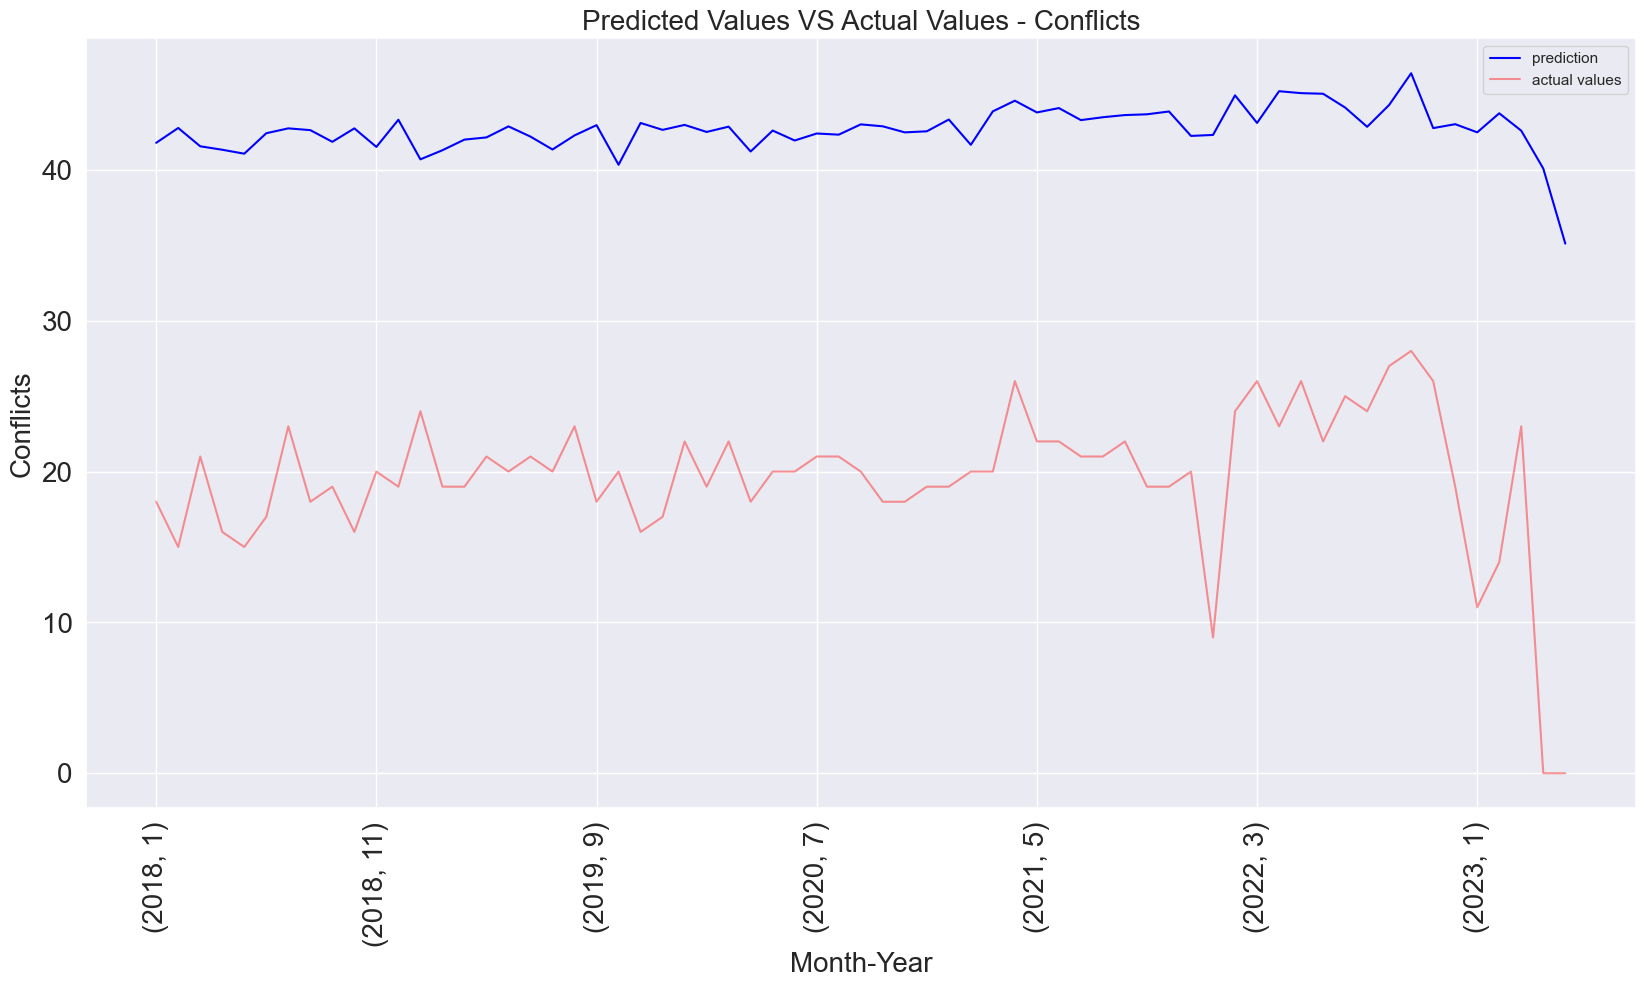

In [66]:
plt.figure(figsize=(20,10))
pa.groupby(['Year', 'Month'])['Prediction'].sum().plot(kind='line', label='prediction', color='blue', alpha=1)
pa.groupby(['Year', 'Month'])['Actual Values'].sum().plot(kind='line', label='actual values', color='red', alpha=0.4)
plt.xticks(rotation=90, size=20)
plt.yticks(size=20)

plt.ylabel('Conflicts', fontsize=20)
plt.xlabel('Month-Year', fontsize=20)
plt.title('Predicted Values VS Actual Values - Conflicts', fontsize=20)
plt.legend()


In [67]:
conf.columns

Index(['deaths', 'wb_pop', 'total_events', 'total_events_gov',
       'total_events_opp', 'share_events_count_events_1',
       'share_events_count_events_2', 'share_events_count_events_3',
       'share_events_count_events_4', 'share_events_count_events_5',
       'share_events_count_events_6', 'share_events_count_events_7',
       'share_events_count_events_8', 'share_events_count_events_9',
       'share_events_count_events_10', 'share_events_count_events_11',
       'share_events_count_events_12', 'share_events_count_events_13',
       'share_events_count_events_14', 'share_events_count_events_15',
       'share_events_count_events_16', 'share_events_count_events_17',
       'share_events_count_events_18', 'share_events_count_events_19',
       'share_events_count_events_20', 'share_events_count_events_1_gov',
       'share_events_count_events_2_gov', 'share_events_count_events_3_gov',
       'share_events_count_events_4_gov', 'share_events_count_events_5_gov',
       'share_events

In [68]:
df_final.month_year

25128    2000-01-01
25129    2000-01-01
25130    2000-01-01
25131    2000-01-01
25132    2000-01-01
            ...    
79870    2023-05-01
79871    2023-05-01
79872    2023-05-01
79873    2023-05-01
79874    2023-05-01
Name: month_year, Length: 54747, dtype: object

In [69]:
conf

,,,deaths,wb_pop,total_events,total_events_gov,total_events_opp,share_events_count_events_1,share_events_count_events_2,share_events_count_events_3,share_events_count_events_4,share_events_count_events_5,...,past6,past12,past60,past120,armedconf_since,num_regions,Adm1_Max,Adm1_Mean,Adm1_Median,country
isocode,month,year,,,,,,,,,,,,,,,,,,,,,
AFG,1,2000,0.002054,0.013818,0.001234,0.001357,0.001280,0.114855,0.045559,0.072741,0.346861,0.089969,...,0.088991,0.031529,0.146054,0.042366,0.000000,0.133047,0.241271,0.304625,0.316220,Afghanistan
AGO,1,2000,0.001370,0.011588,0.001280,0.001977,0.002246,0.131365,0.042804,0.085240,0.254982,0.052768,...,0.031879,0.023356,0.022099,0.022688,0.000000,0.081545,0.072586,0.066002,0.070612,Angola
ALB,1,2000,0.000000,0.002168,0.001282,0.001844,0.001721,0.108656,0.046041,0.081400,0.275875,0.060037,...,0.000000,0.000265,0.000156,0.000024,0.021792,0.055794,0.000023,0.000021,0.000020,Albania
ARE,1,2000,0.000000,0.002299,0.000231,0.000314,0.000126,0.110429,0.026585,0.065440,0.533742,0.051125,...,0.000000,0.000000,0.000000,0.000000,0.322034,0.030043,0.000005,0.000004,0.000004,United Arab Emirates
ARG,1,2000,0.000000,0.026228,0.000579,0.001005,0.000567,0.118174,0.053790,0.114914,0.418093,0.060310,...,0.000000,0.000000,0.000000,0.000030,0.159806,0.077253,0.000589,0.000155,0.000068,Argentina
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XKX,5,2023,0.000000,0.001245,0.000153,0.000177,0.000063,0.092308,0.076923,0.089231,0.307692,0.190769,...,0.000000,0.000000,0.000000,0.000000,0.997579,0.038627,0.000000,0.000000,0.000000,Kosovo
YEM,5,2023,0.000000,0.023333,0.000793,0.000970,0.000987,0.082192,0.046456,0.054199,0.406194,0.107802,...,0.004942,0.003316,0.082242,0.019899,0.004843,0.081545,0.076791,0.063539,0.064971,"Yemen, Rep."
ZAF,5,2023,0.000000,0.042033,0.010216,0.010367,0.002666,0.151882,0.068819,0.066460,0.250162,0.075432,...,0.000000,0.000014,0.000083,0.000013,0.053269,0.042918,0.005656,0.006331,0.007530,South Africa


In [70]:
df_final

,MonthYear,isocode,month,year,deaths,state_deaths,nonstate_deaths,onesided_deaths,civilian_deaths,month_year,...,past6,past12,past60,past120,armedconf_since,num_regions,Adm1_Max,Adm1_Mean,Adm1_Median,country
25128,1970-01-01 00:00:00.000200001,AFG,1,2000,54.0,54.0,0.0,0.0,26.0,2000-01-01,...,16.706907,22.972855,180.652765,346.465884,0,32,629.252033,582.202685,578.869009,Afghanistan
25129,1970-01-01 00:00:00.000200001,AGO,1,2000,36.0,0.0,0.0,36.0,36.0,2000-01-01,...,5.984914,17.017786,27.334553,185.535914,0,20,189.309091,126.144306,129.261468,Angola
25130,1970-01-01 00:00:00.000200001,ALB,1,2000,0.0,0.0,0.0,0.0,0.0,2000-01-01,...,0.000000,0.193002,0.193002,0.193002,9,14,0.060606,0.039237,0.036156,Albania
25131,1970-01-01 00:00:00.000200001,ARE,1,2000,0.0,0.0,0.0,0.0,0.0,2000-01-01,...,0.000000,0.000000,0.000000,0.000000,133,8,0.012346,0.007773,0.007618,United Arab Emirates
25132,1970-01-01 00:00:00.000200001,ARG,1,2000,0.0,0.0,0.0,0.0,0.0,2000-01-01,...,0.000000,0.000000,0.000000,0.249357,66,19,1.535714,0.295357,0.125364,Argentina
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79870,1970-01-01 00:00:00.000202305,XKX,5,2023,0.0,0.0,0.0,0.0,0.0,2023-05-01,...,0.000000,0.000000,0.000000,0.000000,412,10,0.000000,0.000000,0.000000,Kosovo
79871,1970-01-01 00:00:00.000202305,YEM,5,2023,0.0,0.0,0.0,0.0,0.0,2023-05-01,...,0.927789,2.416496,101.723726,162.727194,2,20,200.276596,121.436293,118.934417,"Yemen, Rep."
79872,1970-01-01 00:00:00.000202305,ZAF,5,2023,0.0,0.0,0.0,0.0,0.0,2023-05-01,...,0.000000,0.010102,0.102890,0.108207,22,11,14.751497,12.100576,13.784257,South Africa
79873,1970-01-01 00:00:00.000202305,ZMB,5,2023,0.0,0.0,0.0,0.0,0.0,2023-05-01,...,0.000000,0.000000,0.000000,0.000000,258,11,0.120482,0.065602,0.060748,Zambia


In [71]:
df_final.set_index(['isocode', 'month', 'year'], inplace=True)


In [72]:
armedconfdf.set_index(['isocode', 'month', 'year'], inplace=True)

In [73]:
country

['Equatorial Guinea',
 'Argentina',
 'Ghana',
 'Barbados',
 'Indonesia',
 'Mozambique',
 'Sudan',
 'Cambodia',
 'Liberia',
 'Uruguay',
 'Cabo Verde',
 'Jordan',
 'Guam',
 'Kyrgyz Republic',
 'Iceland',
 'Monaco',
 "Cote d'Ivoire",
 'Libya',
 'Bahrain',
 'Guyana',
 'Bosnia and Herzegovina',
 'Yemen, Rep.',
 'Nigeria',
 'Russian Federation',
 'Malaysia',
 'Antigua and Barbuda',
 'Azerbaijan',
 'Lebanon',
 'Portugal',
 'Tunisia',
 'West Bank and Gaza',
 'Solomon Islands',
 'Colombia',
 'Kosovo',
 'Djibouti',
 'Peru',
 'Sao Tome and Principe',
 'Senegal',
 'Puerto Rico',
 'Tonga',
 'Armenia',
 'Mali',
 'Uganda',
 'Zambia',
 'Chad',
 'Vietnam',
 'Belize',
 'Georgia',
 'Papua New Guinea',
 'Greenland',
 'Japan',
 'France',
 'Bermuda',
 'Syrian Arab Republic',
 'Venezuela, RB',
 'Germany',
 'Dominica',
 'Fiji',
 'Lithuania',
 'Kenya',
 'Marshall Islands',
 'Finland',
 'Macao SAR, China',
 'Kuwait',
 'Burundi',
 'Sierra Leone',
 'Slovenia',
 'Sri Lanka',
 'North Macedonia',
 'Northern Mariana 

In [84]:
def normalization_train_test_split(country):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(country.drop(columns=['armedconf','country','month_year']))
    # create datefrane fir scaled data
    scaled_df=pd.DataFrame(data=scaled,columns=country.drop(columns=['armedconf','country','month_year']).columns, index=country.index)
    scaled_df['armedconf']=list(country.armedconf)
    X_train, X_test,Y_train,Y_test=train_test_split_year(scaled_df, 2018)
    #combine x train and y train as train data 
    train_data=pd.DataFrame()
    train_data[X_train.columns]=X_train
    train_data['armedconf']=Y_train
    #combine x test and y test as test data 
    test_data=pd.DataFrame()
    test_data[X_test.columns]=X_test
    test_data['armedconf']=Y_test

    # using the function to obtian reshaped x_train,x_test,y_train,y_test
    x_train,x_test,y_train,y_test, _ =reshape_data(train_data,test_data)
    return x_train, x_test,y_train,y_test

In [78]:
scaled_df

,deaths,state_deaths,nonstate_deaths,onesided_deaths,civilian_deaths,wb_pop,total_events,total_events_gov,total_events_opp,share_events_count_events_1,...,deaths_state_pc,past6,past12,past60,past120,armedconf_since,num_regions,Adm1_Max,Adm1_Mean,Adm1_Median
0,0.002054,0.002117,0.0,0.000000,0.001888,0.013818,0.001234,0.001357,0.001280,0.114855,...,0.004603,0.088991,0.031529,0.146054,0.042366,0.000000,0.133047,0.241271,0.304625,0.316220
1,0.001370,0.000000,0.0,0.012312,0.002614,0.011588,0.001280,0.001977,0.002246,0.131365,...,0.003658,0.031879,0.023356,0.022099,0.022688,0.000000,0.081545,0.072586,0.066002,0.070612
2,0.000000,0.000000,0.0,0.000000,0.000000,0.002168,0.001282,0.001844,0.001721,0.108656,...,0.000000,0.000000,0.000265,0.000156,0.000024,0.021792,0.055794,0.000023,0.000021,0.000020
3,0.000000,0.000000,0.0,0.000000,0.000000,0.002299,0.000231,0.000314,0.000126,0.110429,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.322034,0.030043,0.000005,0.000004,0.000004
4,0.000000,0.000000,0.0,0.000000,0.000000,0.026228,0.000579,0.001005,0.000567,0.118174,...,0.000000,0.000000,0.000000,0.000000,0.000030,0.159806,0.077253,0.000589,0.000155,0.000068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54742,0.000000,0.000000,0.0,0.000000,0.000000,0.001245,0.000153,0.000177,0.000063,0.092308,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.997579,0.038627,0.000000,0.000000,0.000000
54743,0.000000,0.000000,0.0,0.000000,0.000000,0.023333,0.000793,0.000970,0.000987,0.082192,...,0.000000,0.004942,0.003316,0.082242,0.019899,0.004843,0.081545,0.076791,0.063539,0.064971
54744,0.000000,0.000000,0.0,0.000000,0.000000,0.042033,0.010216,0.010367,0.002666,0.151882,...,0.000000,0.000000,0.000014,0.000083,0.000013,0.053269,0.042918,0.005656,0.006331,0.007530
54745,0.000000,0.000000,0.0,0.000000,0.000000,0.013768,0.000620,0.000917,0.000042,0.146992,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.624697,0.042918,0.000046,0.000034,0.000033


In [75]:
armedconfdf.to_csv('armedconfdf.csv')

Epoch 1/30


2023-06-23 11:38:10.993610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-23 11:38:11.252998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/5 [=================>............] - ETA: 0s - loss: 0.1812 - accuracy: 0.9133 - recall_5: 0.9320

2023-06-23 11:38:11.506586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 1s 80ms/step - loss: 0.1544 - accuracy: 0.9393 - recall_5: 0.9526
Epoch 2/30
5/5 [==============================] - 0s 24ms/step - loss: 0.0390 - accuracy: 0.9860 - recall_5: 1.0000
Epoch 3/30
5/5 [==============================] - 0s 24ms/step - loss: 0.0169 - accuracy: 0.9860 - recall_5: 1.0000
Epoch 4/30
5/5 [==============================] - 0s 19ms/step - loss: 0.0141 - accuracy: 0.9860 - recall_5: 1.0000
Epoch 5/30
5/5 [==============================] - 0s 20ms/step - loss: 0.0144 - accuracy: 0.9860 - recall_5: 1.0000
Epoch 6/30
5/5 [==============================] - 0s 14ms/step - loss: 0.0150 - accuracy: 0.9860 - recall_5: 1.0000
Epoch 7/30
5/5 [==============================] - 0s 18ms/step - loss: 0.0152 - accuracy: 0.9860 - recall_5: 1.0000
Epoch 8/30
5/5 [==============================] - 0s 14ms/step - loss: 0.0152 - accuracy: 0.9860 - recall_5: 1.0000
Epoch 9/30
5/5 [==============================] - 0s 15ms/step - loss: 0.0149 - acc

2023-06-23 11:38:14.314066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-23 11:38:14.364085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Afghanistan - Precision: 0.9047619047619048


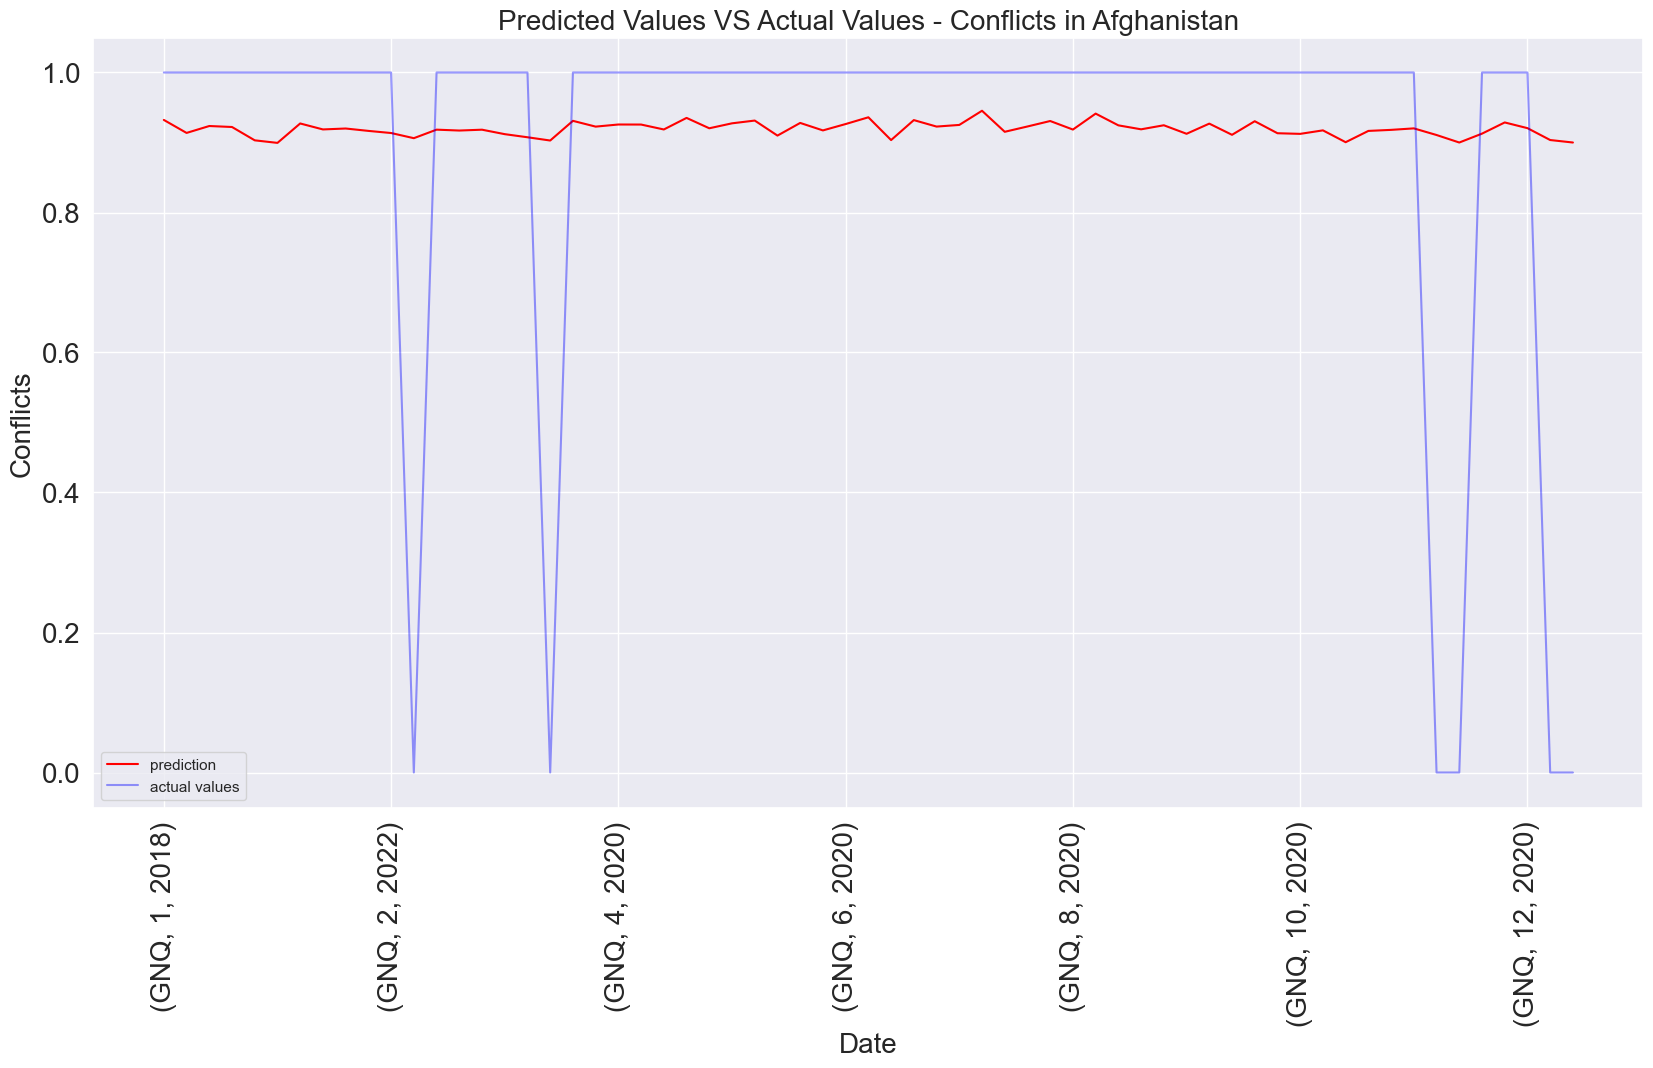

Epoch 1/30


2023-06-23 11:38:15.180557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-23 11:38:15.361476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/5 [=====>........................] - ETA: 4s - loss: 2.5702 - accuracy: 0.5600 - recall_6: 0.6667

2023-06-23 11:38:15.619709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 1s 81ms/step - loss: 1.9251 - accuracy: 0.8598 - recall_6: 0.9286
Epoch 2/30
5/5 [==============================] - 0s 19ms/step - loss: 0.7411 - accuracy: 0.9159 - recall_6: 1.0000
Epoch 3/30
5/5 [==============================] - 0s 21ms/step - loss: 0.5714 - accuracy: 0.9159 - recall_6: 1.0000
Epoch 4/30
5/5 [==============================] - 0s 18ms/step - loss: 0.6128 - accuracy: 0.9159 - recall_6: 1.0000
Epoch 5/30
5/5 [==============================] - 0s 22ms/step - loss: 0.6487 - accuracy: 0.9159 - recall_6: 1.0000
Epoch 6/30
5/5 [==============================] - 0s 15ms/step - loss: 0.6476 - accuracy: 0.9159 - recall_6: 1.0000
Epoch 7/30
5/5 [==============================] - 0s 15ms/step - loss: 0.6225 - accuracy: 0.9159 - recall_6: 1.0000
Epoch 8/30
5/5 [==============================] - 0s 15ms/step - loss: 0.5900 - accuracy: 0.9159 - recall_6: 1.0000
Epoch 9/30
5/5 [==============================] - 0s 16ms/step - loss: 0.5611 - acc

2023-06-23 11:38:18.339393: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-23 11:38:18.388059: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Somalia - Precision: 0.9523809523809523


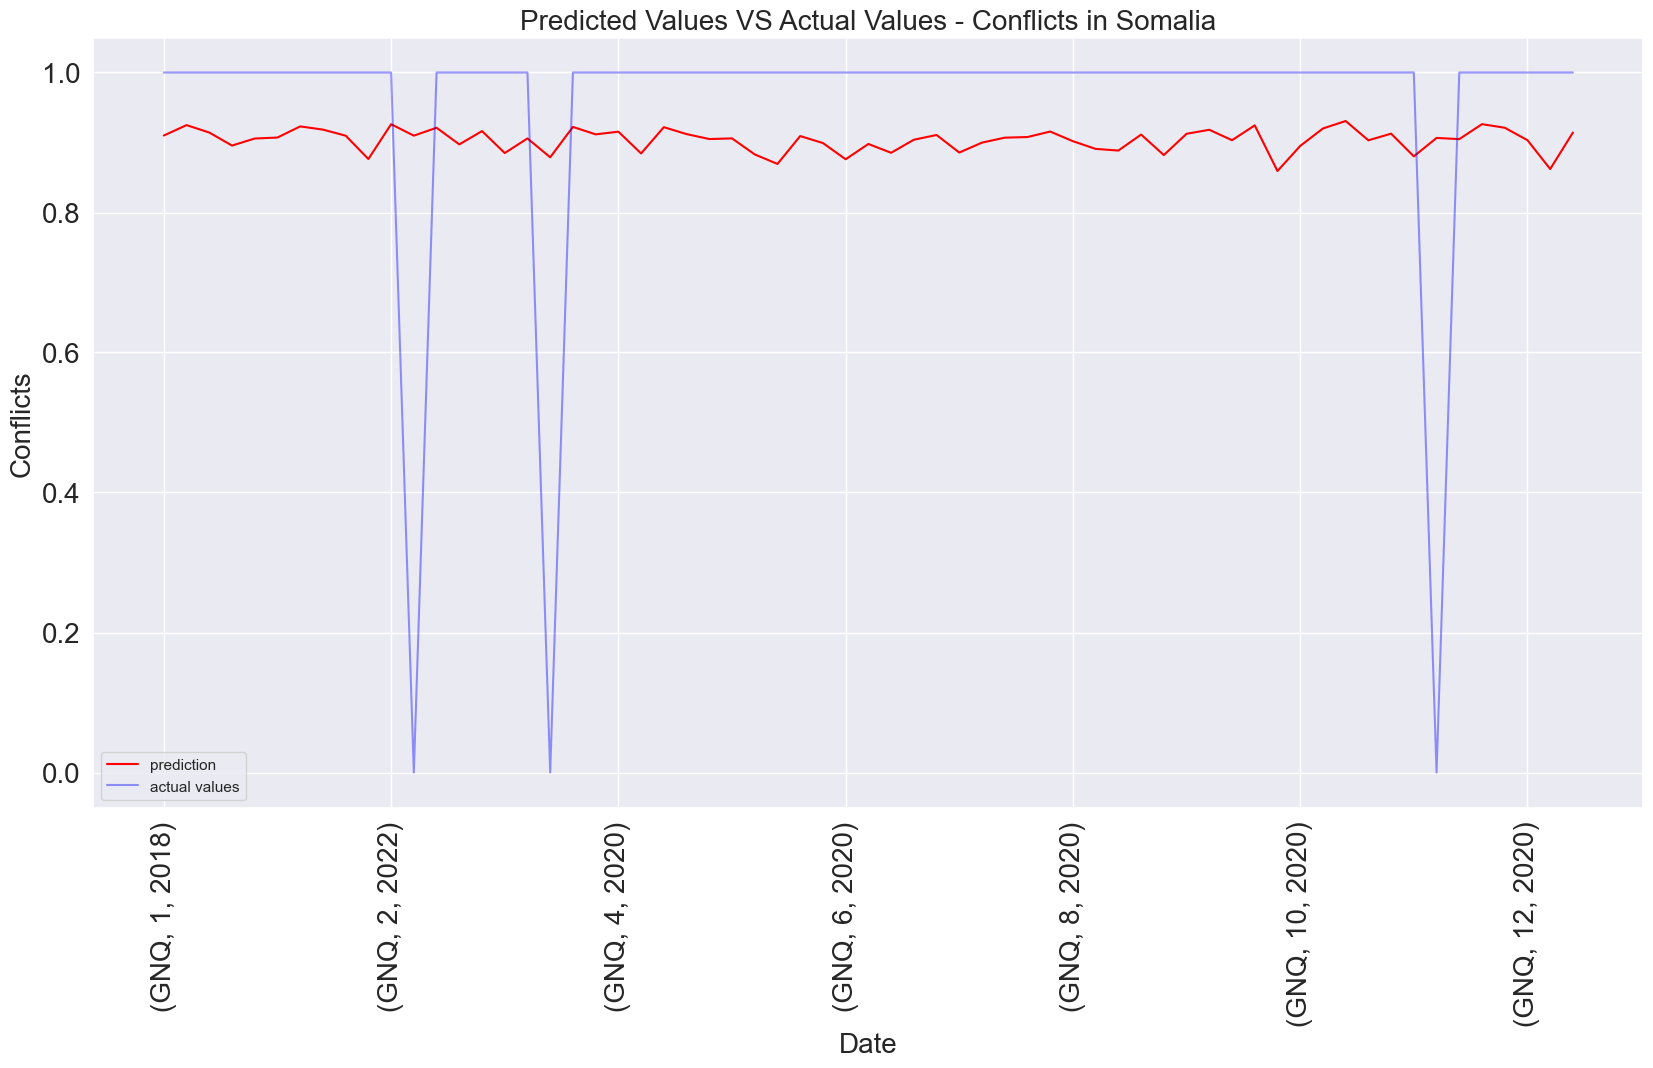

Epoch 1/30


2023-06-23 11:38:19.219249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-23 11:38:19.404897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/5 [=====>........................] - ETA: 4s - loss: 0.6450 - accuracy: 0.5400 - recall_7: 0.5000

2023-06-23 11:38:19.664741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 1s 85ms/step - loss: 0.9539 - accuracy: 0.8178 - recall_7: 0.8793
Epoch 2/30
5/5 [==============================] - 0s 26ms/step - loss: 0.4201 - accuracy: 0.8131 - recall_7: 1.0000
Epoch 3/30
5/5 [==============================] - 0s 20ms/step - loss: 0.3644 - accuracy: 0.8131 - recall_7: 1.0000
Epoch 4/30
5/5 [==============================] - 0s 20ms/step - loss: 0.3953 - accuracy: 0.8131 - recall_7: 1.0000
Epoch 5/30
5/5 [==============================] - 0s 19ms/step - loss: 0.4003 - accuracy: 0.8131 - recall_7: 1.0000
Epoch 6/30
5/5 [==============================] - 0s 16ms/step - loss: 0.3760 - accuracy: 0.8131 - recall_7: 1.0000
Epoch 7/30
5/5 [==============================] - 0s 14ms/step - loss: 0.3395 - accuracy: 0.8131 - recall_7: 1.0000
Epoch 8/30
5/5 [==============================] - 0s 14ms/step - loss: 0.3039 - accuracy: 0.8131 - recall_7: 1.0000
Epoch 9/30
5/5 [==============================] - 0s 12ms/step - loss: 0.2746 - acc

2023-06-23 11:38:22.435045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-23 11:38:22.484072: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Iraq - Precision: 0.9206349206349206


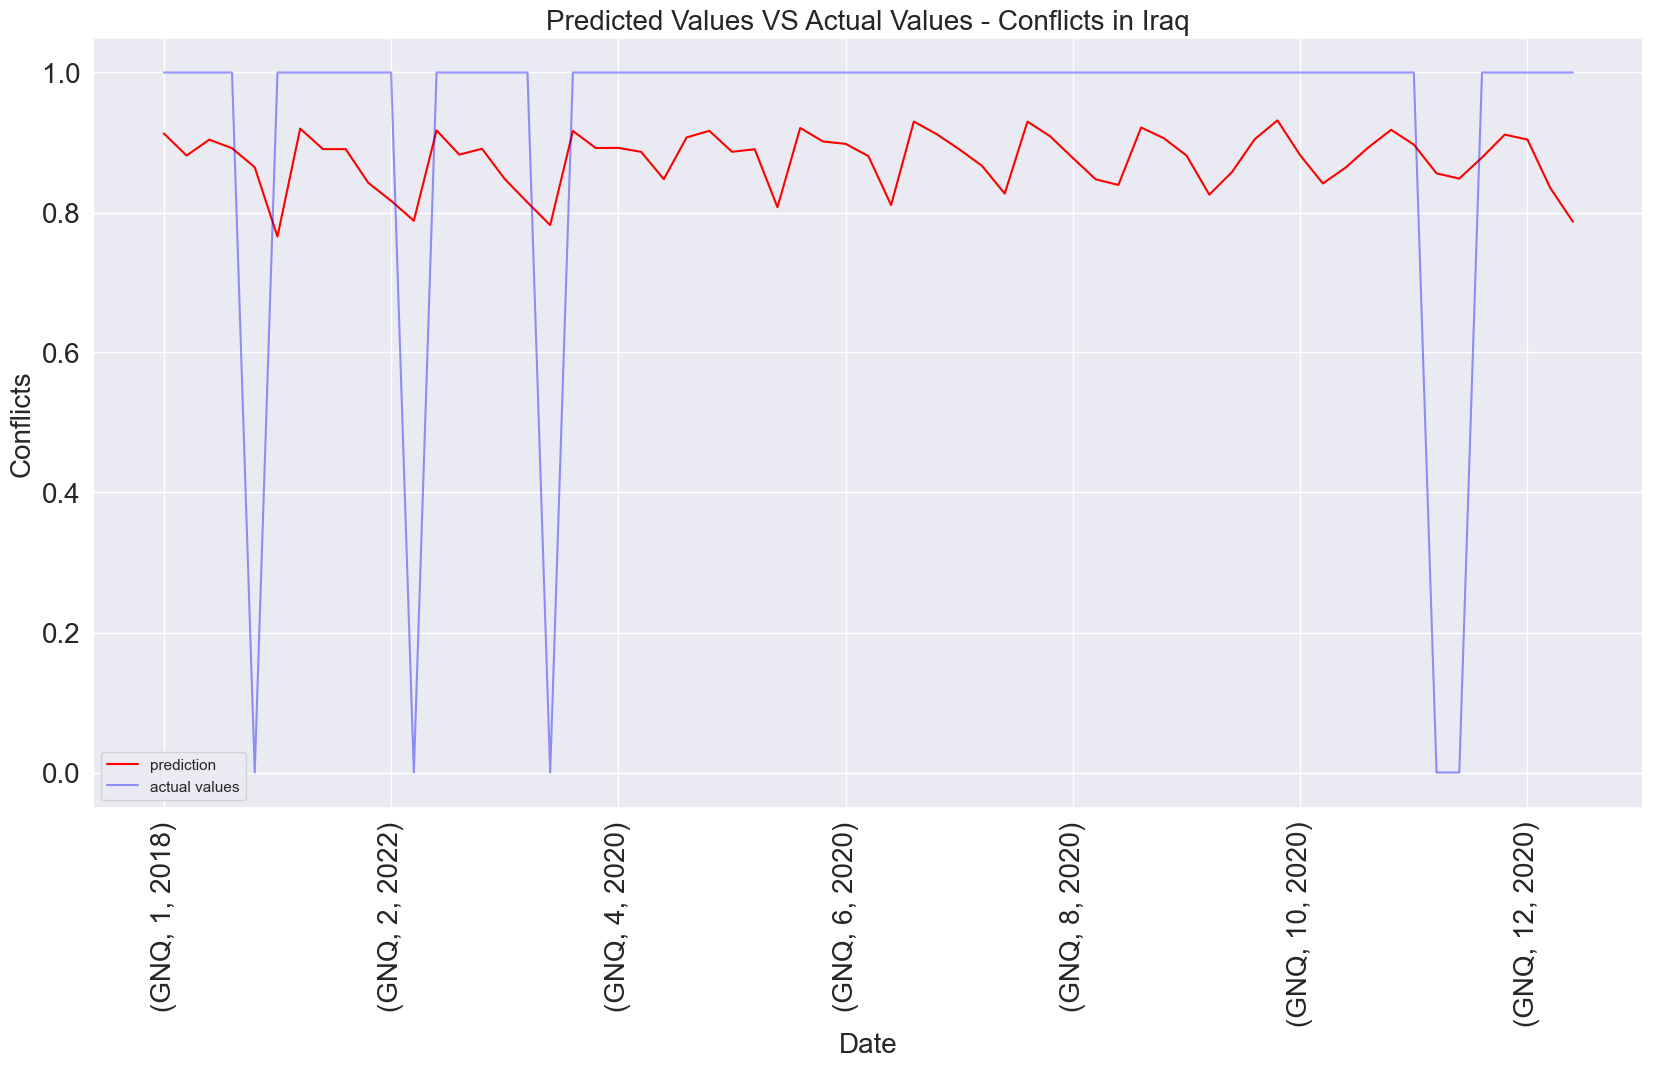

Epoch 1/30


2023-06-23 11:38:23.332654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-23 11:38:23.521759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/5 [=================>............] - ETA: 0s - loss: 0.2063 - accuracy: 0.8200 - recall_8: 0.9531

2023-06-23 11:38:23.792212: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 1s 78ms/step - loss: 0.1848 - accuracy: 0.8364 - recall_8: 0.9674
Epoch 2/30
5/5 [==============================] - 0s 29ms/step - loss: 0.0974 - accuracy: 0.8598 - recall_8: 1.0000
Epoch 3/30
5/5 [==============================] - 0s 26ms/step - loss: 0.0944 - accuracy: 0.8598 - recall_8: 1.0000
Epoch 4/30
5/5 [==============================] - 0s 18ms/step - loss: 0.0948 - accuracy: 0.8598 - recall_8: 1.0000
Epoch 5/30
5/5 [==============================] - 0s 17ms/step - loss: 0.0918 - accuracy: 0.8598 - recall_8: 1.0000
Epoch 6/30
5/5 [==============================] - 0s 16ms/step - loss: 0.0907 - accuracy: 0.8598 - recall_8: 1.0000
Epoch 7/30
5/5 [==============================] - 0s 15ms/step - loss: 0.0918 - accuracy: 0.8598 - recall_8: 1.0000
Epoch 8/30
5/5 [==============================] - 0s 13ms/step - loss: 0.0924 - accuracy: 0.8598 - recall_8: 1.0000
Epoch 9/30
5/5 [==============================] - 0s 15ms/step - loss: 0.0911 - acc

2023-06-23 11:38:26.526936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-23 11:38:26.577033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Sudan - Precision: 0.5714285714285714


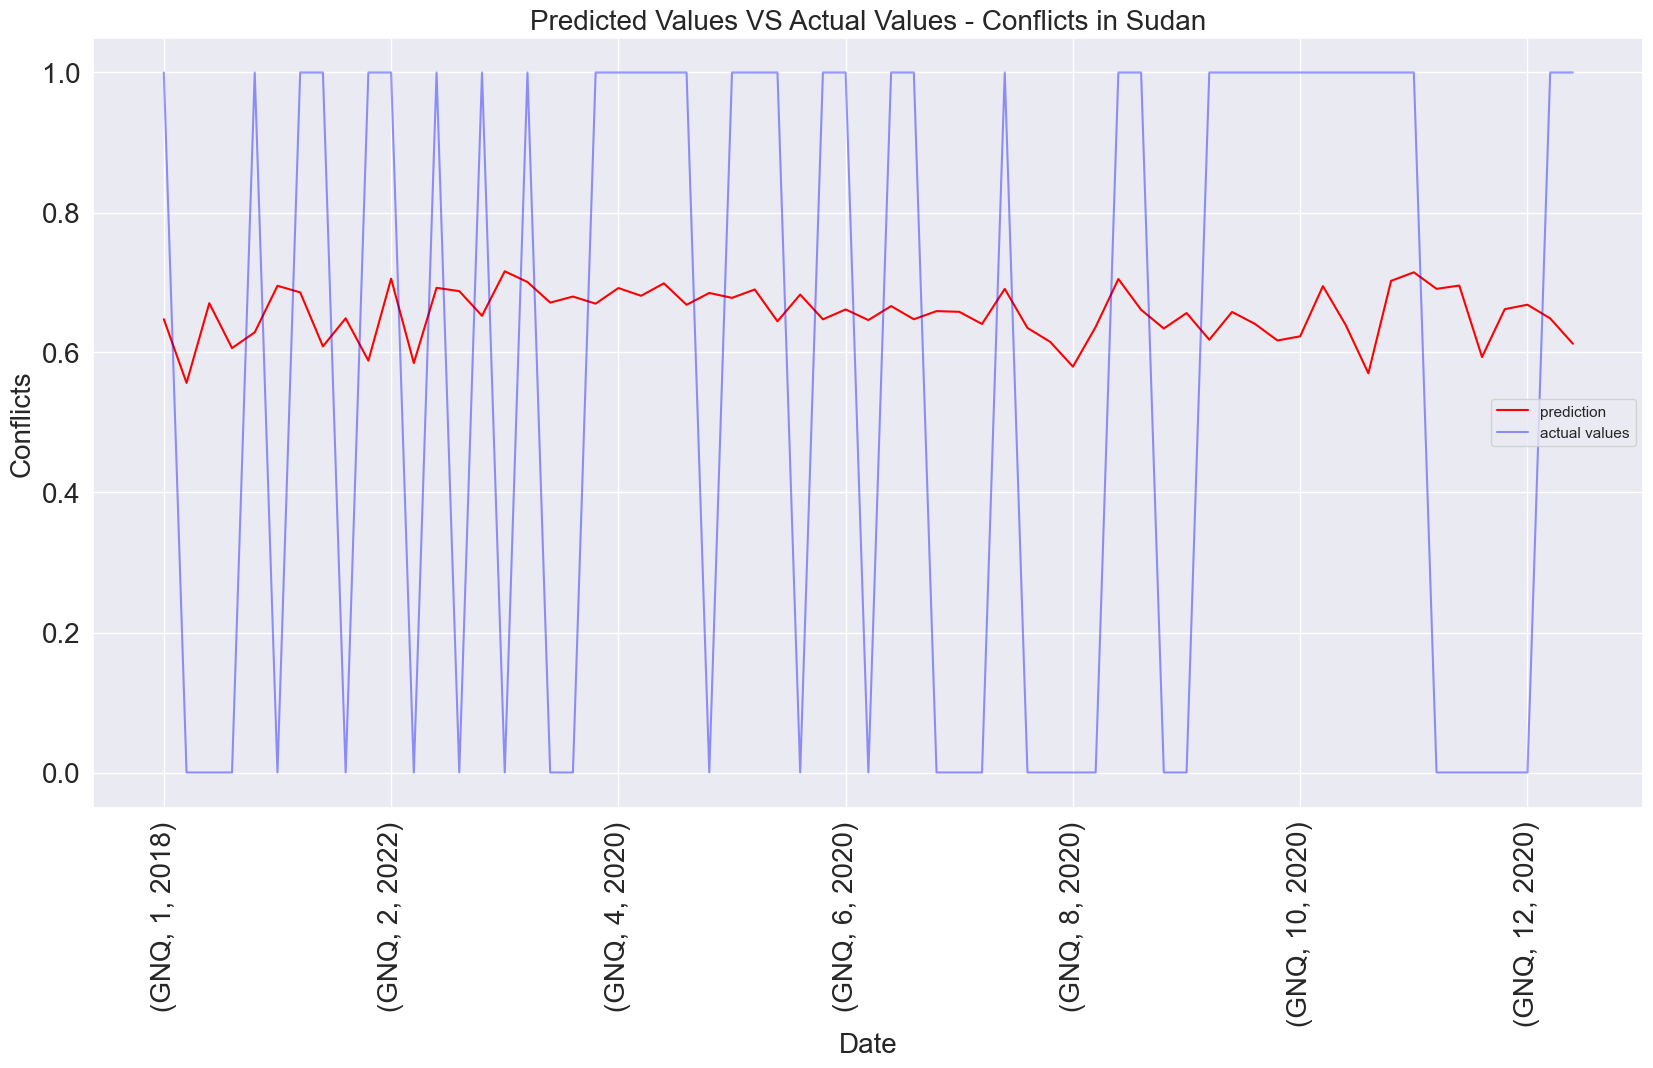

Epoch 1/30


2023-06-23 11:38:27.390678: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-23 11:38:27.586635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/5 [=====>........................] - ETA: 4s - loss: 0.2960 - accuracy: 0.6000 - recall_9: 0.7250

2023-06-23 11:38:27.891425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 1s 93ms/step - loss: 0.2289 - accuracy: 0.6589 - recall_9: 0.9211
Epoch 2/30
5/5 [==============================] - 0s 40ms/step - loss: 0.1675 - accuracy: 0.7103 - recall_9: 1.0000
Epoch 3/30
5/5 [==============================] - 0s 27ms/step - loss: 0.1786 - accuracy: 0.7103 - recall_9: 1.0000
Epoch 4/30
5/5 [==============================] - 0s 15ms/step - loss: 0.1810 - accuracy: 0.7103 - recall_9: 1.0000
Epoch 5/30
5/5 [==============================] - 0s 21ms/step - loss: 0.1718 - accuracy: 0.7103 - recall_9: 1.0000
Epoch 6/30
5/5 [==============================] - 0s 14ms/step - loss: 0.1630 - accuracy: 0.7103 - recall_9: 1.0000
Epoch 7/30
5/5 [==============================] - 0s 17ms/step - loss: 0.1586 - accuracy: 0.7103 - recall_9: 1.0000
Epoch 8/30
5/5 [==============================] - 0s 14ms/step - loss: 0.1560 - accuracy: 0.7103 - recall_9: 1.0000
Epoch 9/30
5/5 [==============================] - 0s 13ms/step - loss: 0.1537 - acc

2023-06-23 11:38:30.793573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-23 11:38:30.841904: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Congo, Dem. Rep. - Precision: 0.9365079365079365


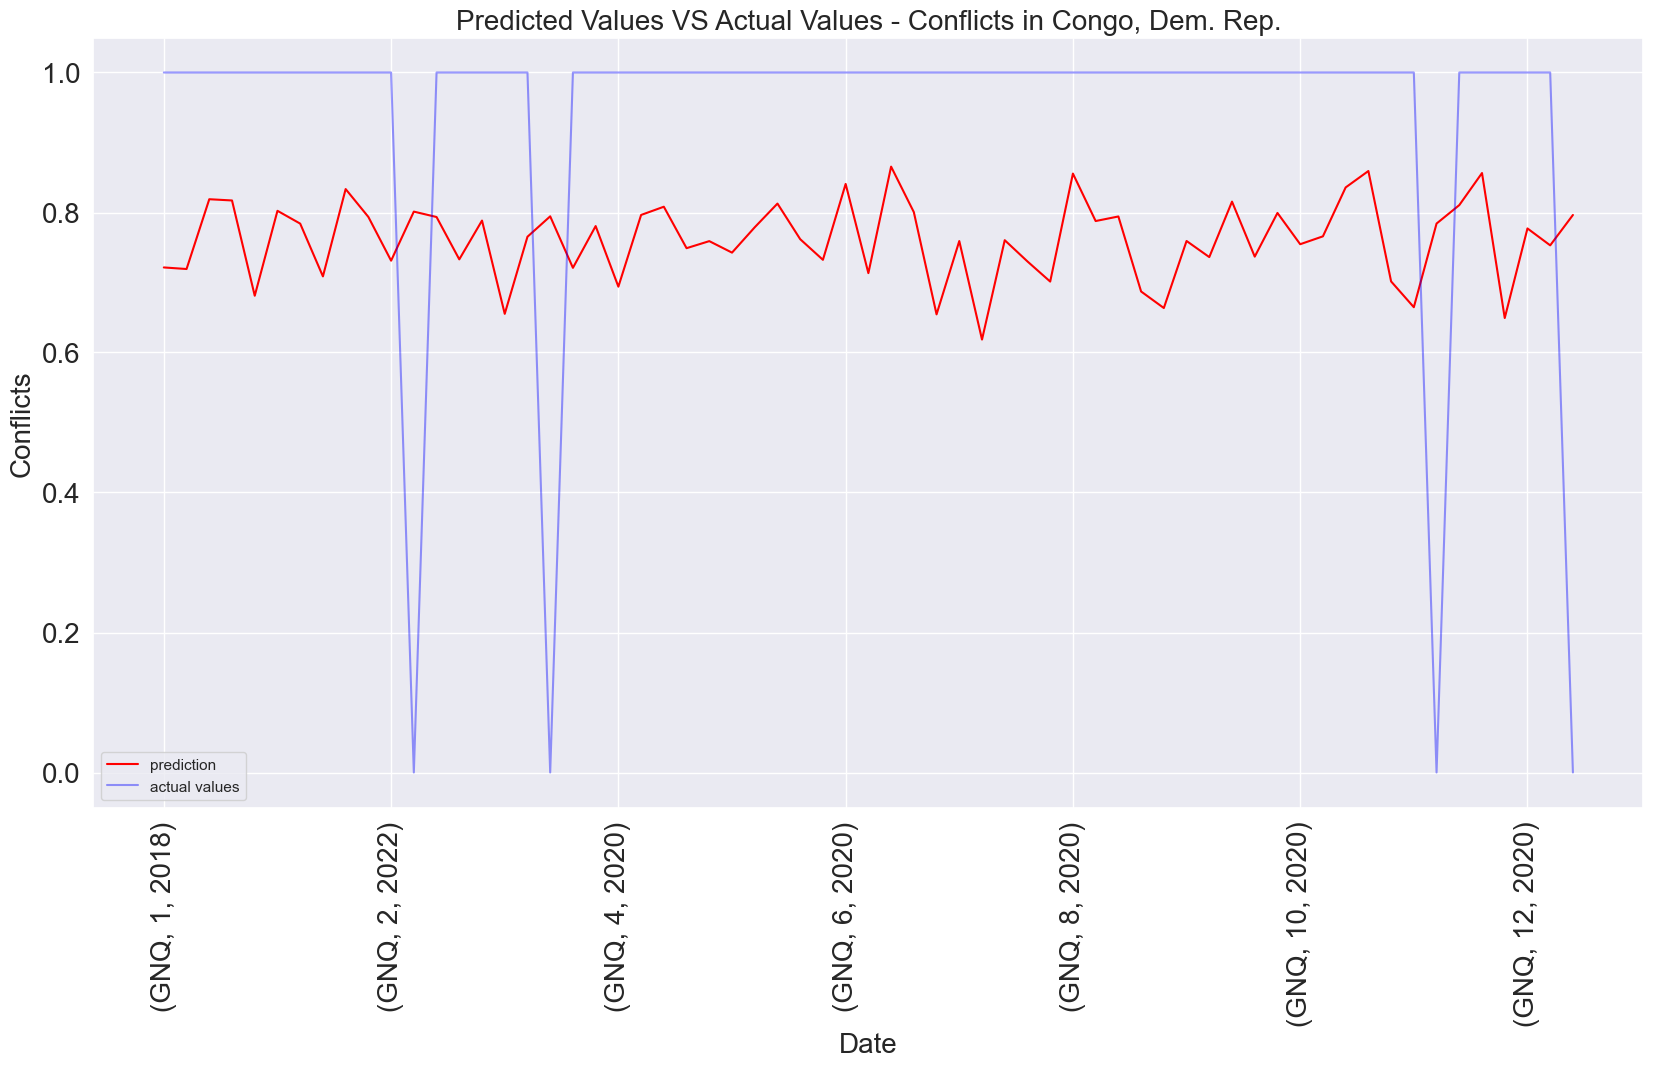

Epoch 1/30


2023-06-23 11:38:32.938913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-23 11:38:33.206933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/5 [=====>........................] - ETA: 4s - loss: 0.2281 - accuracy: 0.6000 - recall_10: 0.8571

2023-06-23 11:38:33.551547: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 2s 119ms/step - loss: 0.3798 - accuracy: 0.6028 - recall_10: 0.4737
Epoch 2/30
5/5 [==============================] - 0s 35ms/step - loss: 0.2712 - accuracy: 0.5654 - recall_10: 1.0000
Epoch 3/30
5/5 [==============================] - 0s 27ms/step - loss: 0.2551 - accuracy: 0.5327 - recall_10: 1.0000
Epoch 4/30
5/5 [==============================] - 0s 23ms/step - loss: 0.2689 - accuracy: 0.5327 - recall_10: 1.0000
Epoch 5/30
5/5 [==============================] - 0s 15ms/step - loss: 0.2737 - accuracy: 0.5327 - recall_10: 1.0000
Epoch 6/30
5/5 [==============================] - 0s 26ms/step - loss: 0.2641 - accuracy: 0.5327 - recall_10: 1.0000
Epoch 7/30
5/5 [==============================] - 0s 16ms/step - loss: 0.2492 - accuracy: 0.5327 - recall_10: 1.0000
Epoch 8/30
5/5 [==============================] - 0s 20ms/step - loss: 0.2358 - accuracy: 0.5374 - recall_10: 1.0000
Epoch 9/30
5/5 [==============================] - 0s 13ms/step - loss: 0.2

2023-06-23 11:38:36.644425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-23 11:38:36.692056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Central African Republic - Precision: 0.9047619047619048


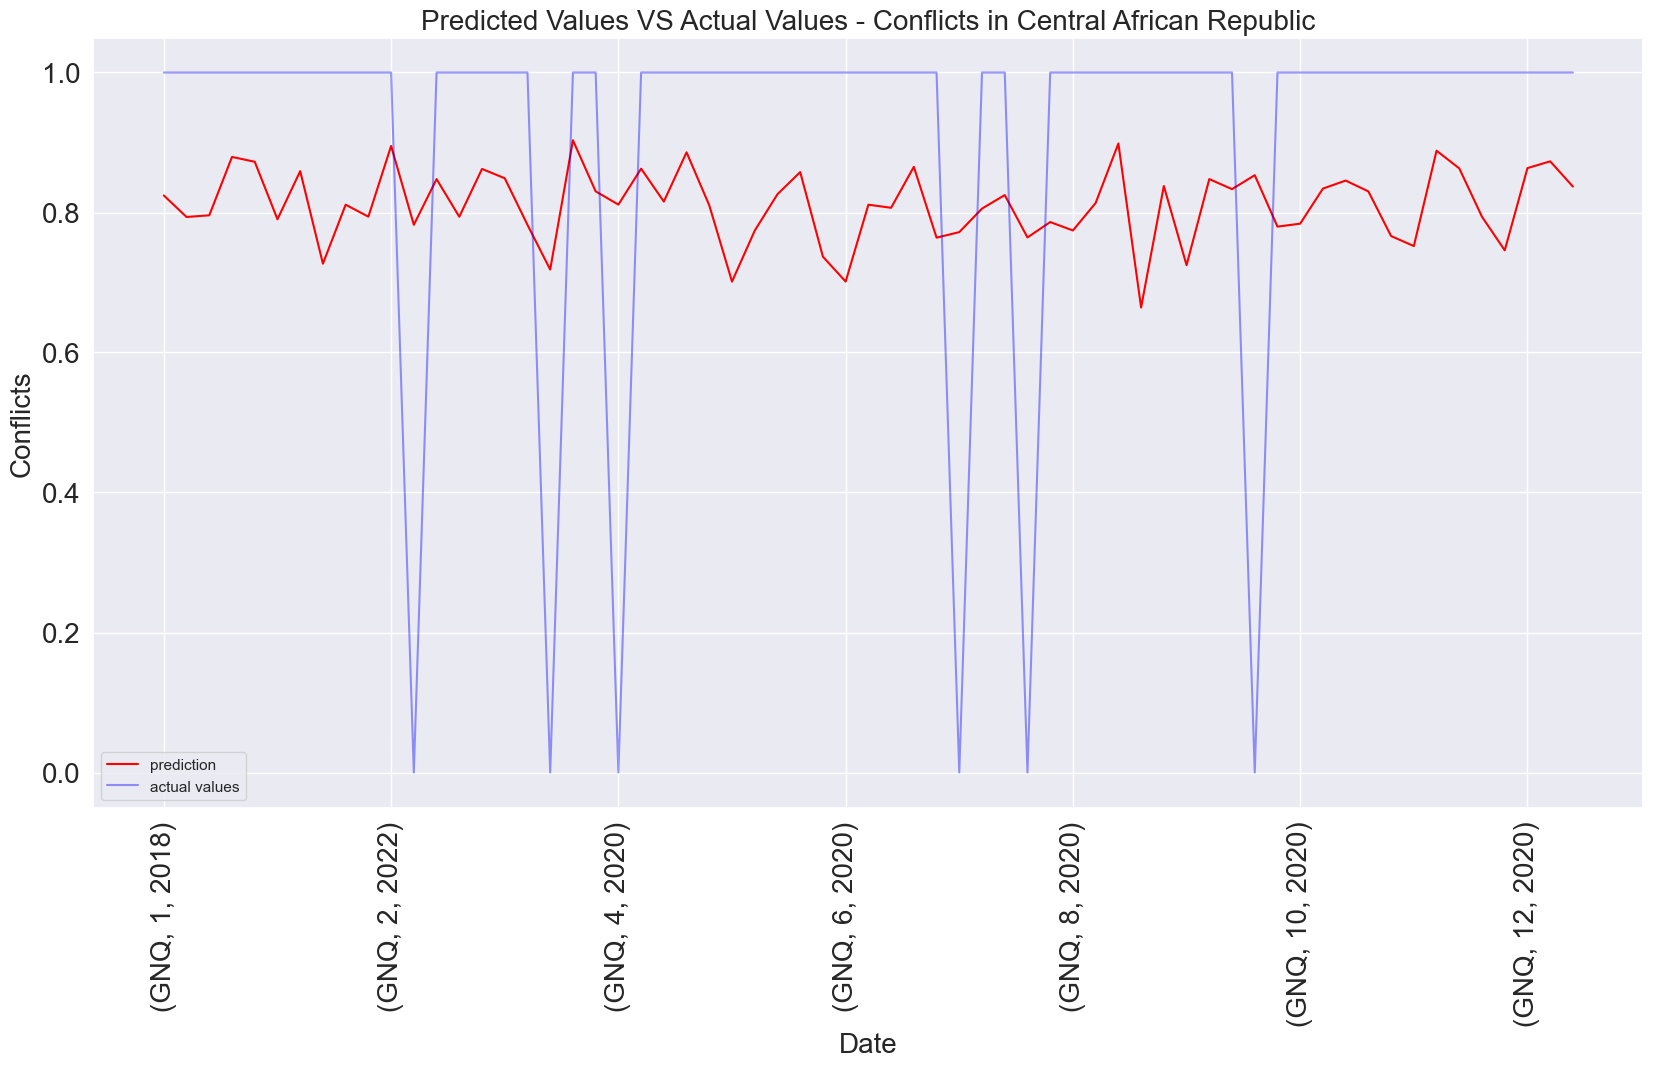

Epoch 1/30


2023-06-23 11:38:37.534906: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-23 11:38:37.748496: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/5 [=====>........................] - ETA: 4s - loss: 0.2506 - accuracy: 0.4200 - recall_11: 0.7857

2023-06-23 11:38:38.066896: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 2s 115ms/step - loss: 0.3183 - accuracy: 0.4439 - recall_11: 0.5152
Epoch 2/30
5/5 [==============================] - 0s 32ms/step - loss: 0.2346 - accuracy: 0.4673 - recall_11: 0.9899
Epoch 3/30
5/5 [==============================] - 0s 18ms/step - loss: 0.2443 - accuracy: 0.4626 - recall_11: 1.0000
Epoch 4/30
5/5 [==============================] - 0s 27ms/step - loss: 0.2573 - accuracy: 0.4626 - recall_11: 1.0000
Epoch 5/30
5/5 [==============================] - 0s 18ms/step - loss: 0.2460 - accuracy: 0.4626 - recall_11: 1.0000
Epoch 6/30
5/5 [==============================] - 0s 17ms/step - loss: 0.2254 - accuracy: 0.4626 - recall_11: 1.0000
Epoch 7/30
5/5 [==============================] - 0s 14ms/step - loss: 0.2084 - accuracy: 0.4813 - recall_11: 1.0000
Epoch 8/30
5/5 [==============================] - 0s 22ms/step - loss: 0.1957 - accuracy: 0.5093 - recall_11: 0.9798
Epoch 9/30
5/5 [==============================] - 0s 17ms/step - loss: 0.1

2023-06-23 11:38:41.106912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-23 11:38:41.155460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Nigeria - Precision: 0.8888888888888888


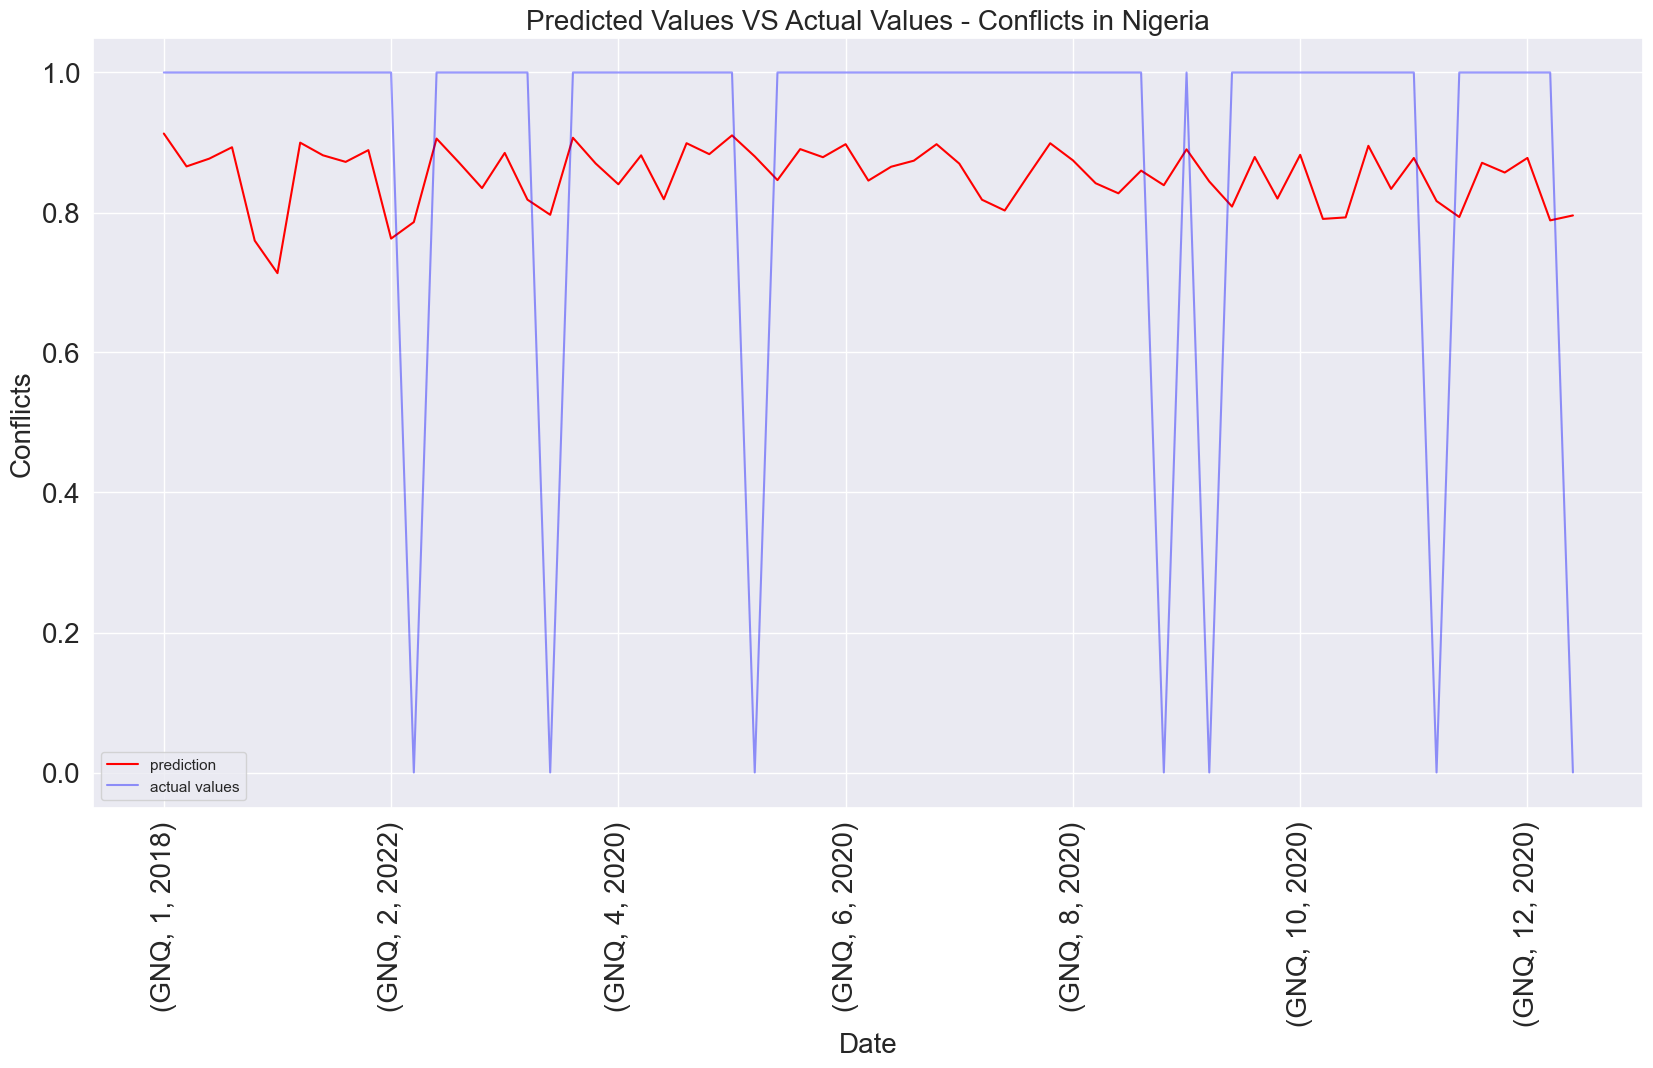

Epoch 1/30


2023-06-23 11:38:42.004859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-23 11:38:42.193394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/5 [=====>........................] - ETA: 4s - loss: 0.5091 - accuracy: 0.8000 - recall_12: 0.8864

2023-06-23 11:38:42.499773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 2s 127ms/step - loss: 0.3828 - accuracy: 0.6075 - recall_12: 0.9627
Epoch 2/30
5/5 [==============================] - 0s 38ms/step - loss: 0.2699 - accuracy: 0.6262 - recall_12: 1.0000
Epoch 3/30
5/5 [==============================] - 0s 24ms/step - loss: 0.2479 - accuracy: 0.6262 - recall_12: 1.0000
Epoch 4/30
5/5 [==============================] - 0s 28ms/step - loss: 0.2315 - accuracy: 0.6262 - recall_12: 1.0000
Epoch 5/30
5/5 [==============================] - 0s 28ms/step - loss: 0.2237 - accuracy: 0.6262 - recall_12: 1.0000
Epoch 6/30
5/5 [==============================] - 0s 22ms/step - loss: 0.2223 - accuracy: 0.6262 - recall_12: 1.0000
Epoch 7/30
5/5 [==============================] - 0s 20ms/step - loss: 0.2186 - accuracy: 0.6308 - recall_12: 1.0000
Epoch 8/30
5/5 [==============================] - 0s 13ms/step - loss: 0.2097 - accuracy: 0.6308 - recall_12: 1.0000
Epoch 9/30
5/5 [==============================] - 0s 18ms/step - loss: 0.1

2023-06-23 11:38:45.703894: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-23 11:38:45.756503: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Israel - Precision: 0.36363636363636365


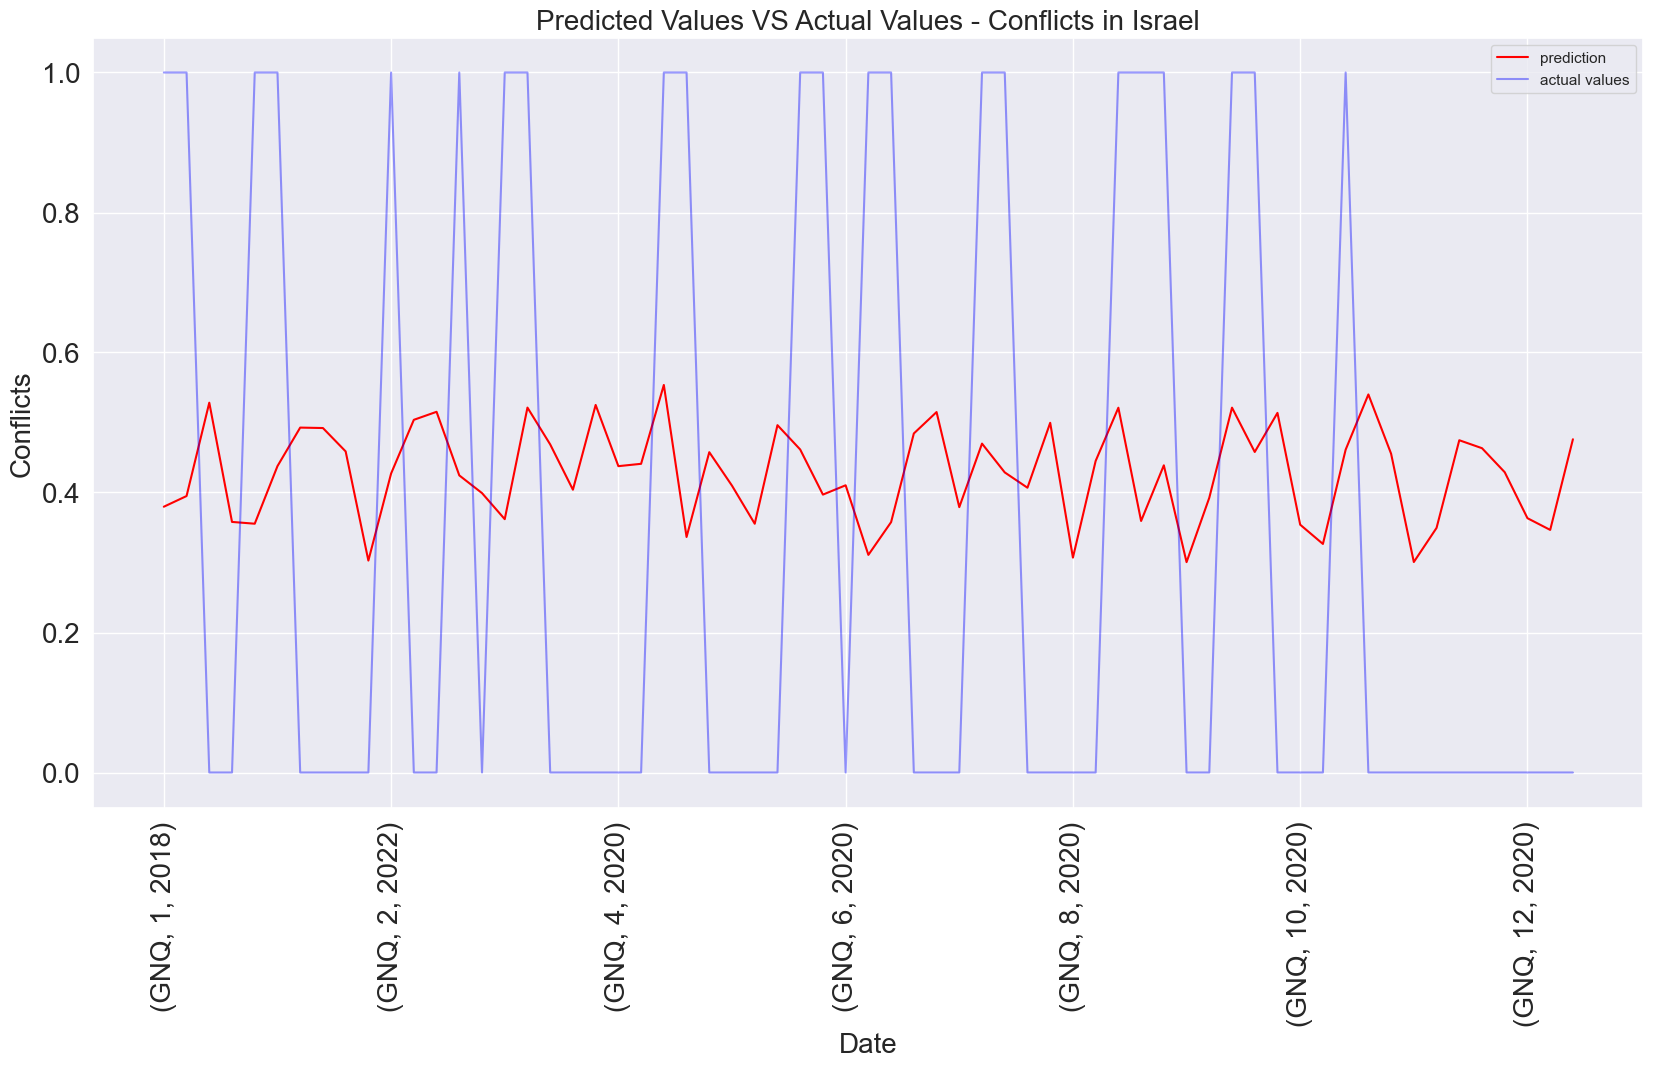

Epoch 1/30


2023-06-23 11:38:46.688381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-23 11:38:46.880110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/5 [=====>........................] - ETA: 4s - loss: 0.1471 - accuracy: 0.5800 - recall_13: 0.0000e+00

2023-06-23 11:38:47.198308: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 2s 128ms/step - loss: 0.3352 - accuracy: 0.4720 - recall_13: 0.0111
Epoch 2/30
5/5 [==============================] - 0s 57ms/step - loss: 0.2228 - accuracy: 0.7523 - recall_13: 0.9778
Epoch 3/30
5/5 [==============================] - 0s 41ms/step - loss: 0.1983 - accuracy: 0.4206 - recall_13: 1.0000
Epoch 4/30
5/5 [==============================] - 0s 15ms/step - loss: 0.2042 - accuracy: 0.4206 - recall_13: 1.0000 
Epoch 5/30
5/5 [==============================] - 0s 24ms/step - loss: 0.2085 - accuracy: 0.4206 - recall_13: 1.0000 
Epoch 6/30
5/5 [==============================] - 0s 17ms/step - loss: 0.2013 - accuracy: 0.4206 - recall_13: 1.0000 
Epoch 7/30
5/5 [==============================] - 0s 21ms/step - loss: 0.1862 - accuracy: 0.4206 - recall_13: 1.0000 
Epoch 8/30
5/5 [==============================] - 0s 24ms/step - loss: 0.1695 - accuracy: 0.4486 - recall_13: 0.9889
Epoch 9/30
5/5 [==============================] - 0s 20ms/step - loss:

2023-06-23 11:38:50.525838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-23 11:38:50.574667: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Yemen, Rep. - Precision: 0.9523809523809523


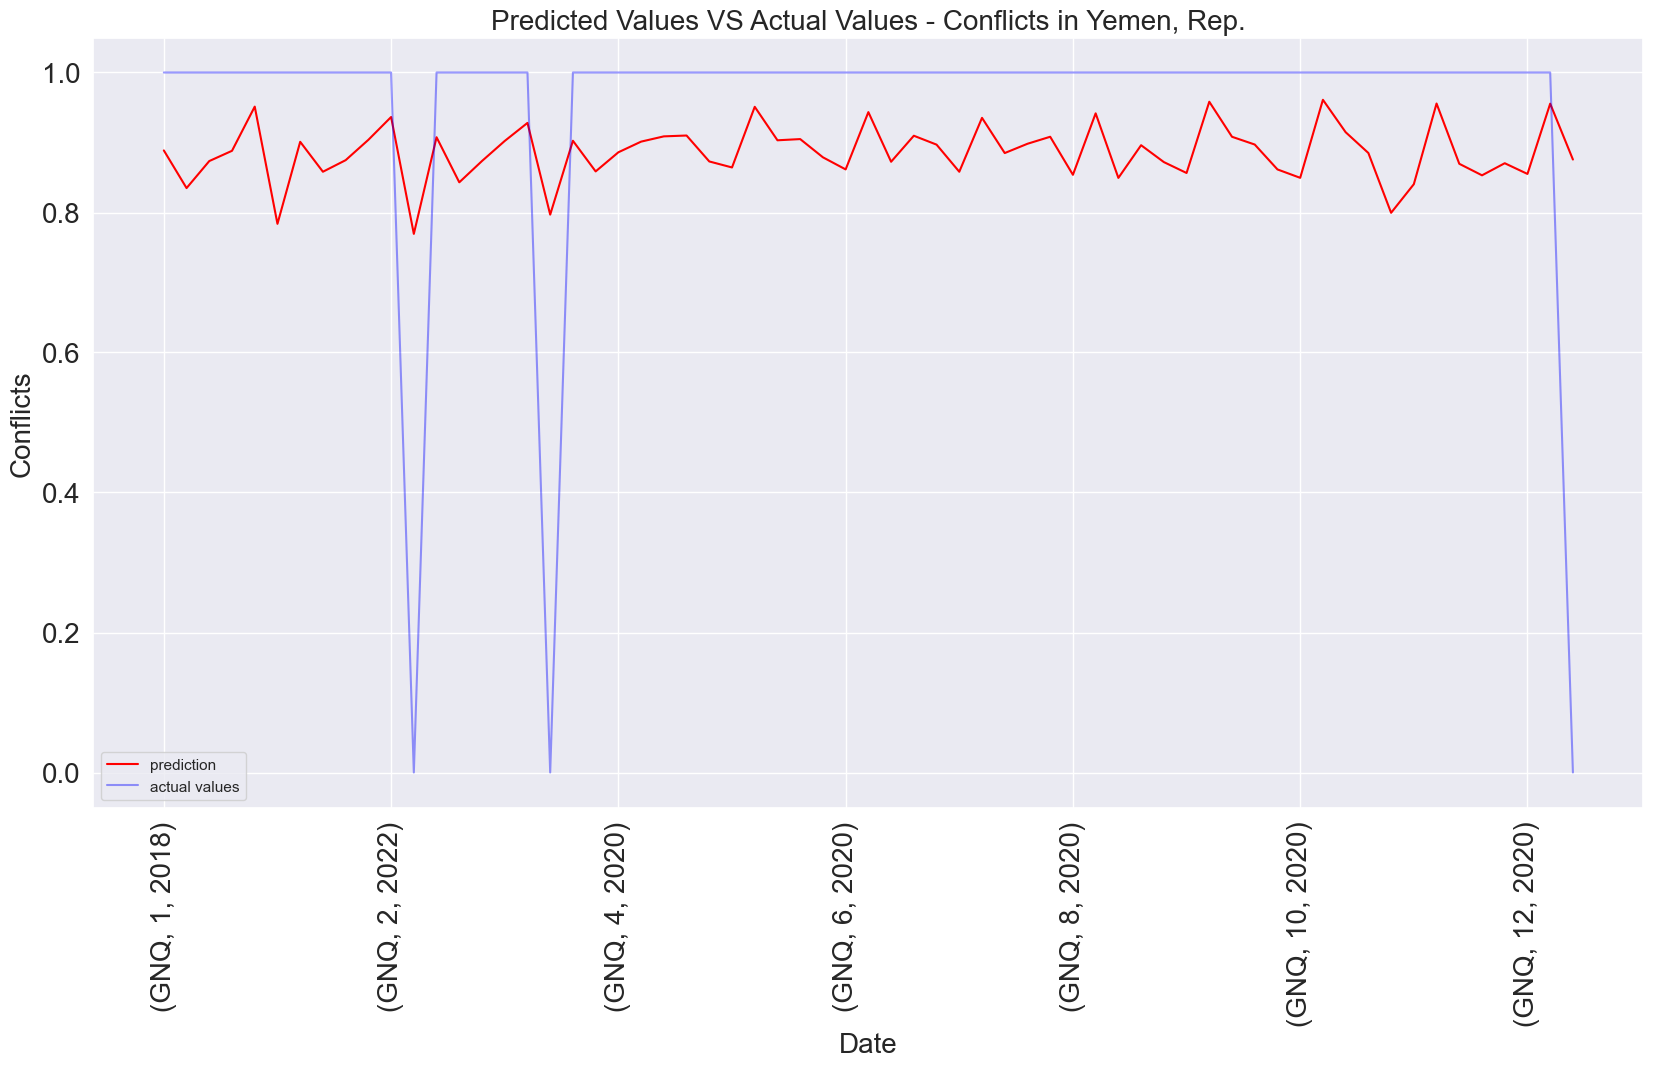

Epoch 1/30


2023-06-23 11:38:52.641184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-23 11:38:53.017982: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/5 [=====>........................] - ETA: 10s - loss: 0.1465 - accuracy: 0.4400 - recall_14: 0.0000e+00

2023-06-23 11:38:53.411268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 3s 145ms/step - loss: 0.3061 - accuracy: 0.4720 - recall_14: 0.0122
Epoch 2/30
5/5 [==============================] - 0s 46ms/step - loss: 0.1825 - accuracy: 0.9393 - recall_14: 0.9634
Epoch 3/30
5/5 [==============================] - 0s 38ms/step - loss: 0.1526 - accuracy: 0.4860 - recall_14: 1.0000
Epoch 4/30
5/5 [==============================] - 0s 39ms/step - loss: 0.1492 - accuracy: 0.4112 - recall_14: 1.0000
Epoch 5/30
5/5 [==============================] - 0s 29ms/step - loss: 0.1417 - accuracy: 0.4252 - recall_14: 1.0000
Epoch 6/30
5/5 [==============================] - 0s 21ms/step - loss: 0.1240 - accuracy: 0.5374 - recall_14: 1.0000
Epoch 7/30
5/5 [==============================] - 0s 23ms/step - loss: 0.1021 - accuracy: 0.7850 - recall_14: 0.9878
Epoch 8/30
5/5 [==============================] - 0s 14ms/step - loss: 0.0824 - accuracy: 0.9439 - recall_14: 0.9878
Epoch 9/30
5/5 [==============================] - 0s 15ms/step - loss: 0.0

2023-06-23 11:38:56.862478: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-23 11:38:56.919658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Syrian Arab Republic - Precision: 0.9365079365079365


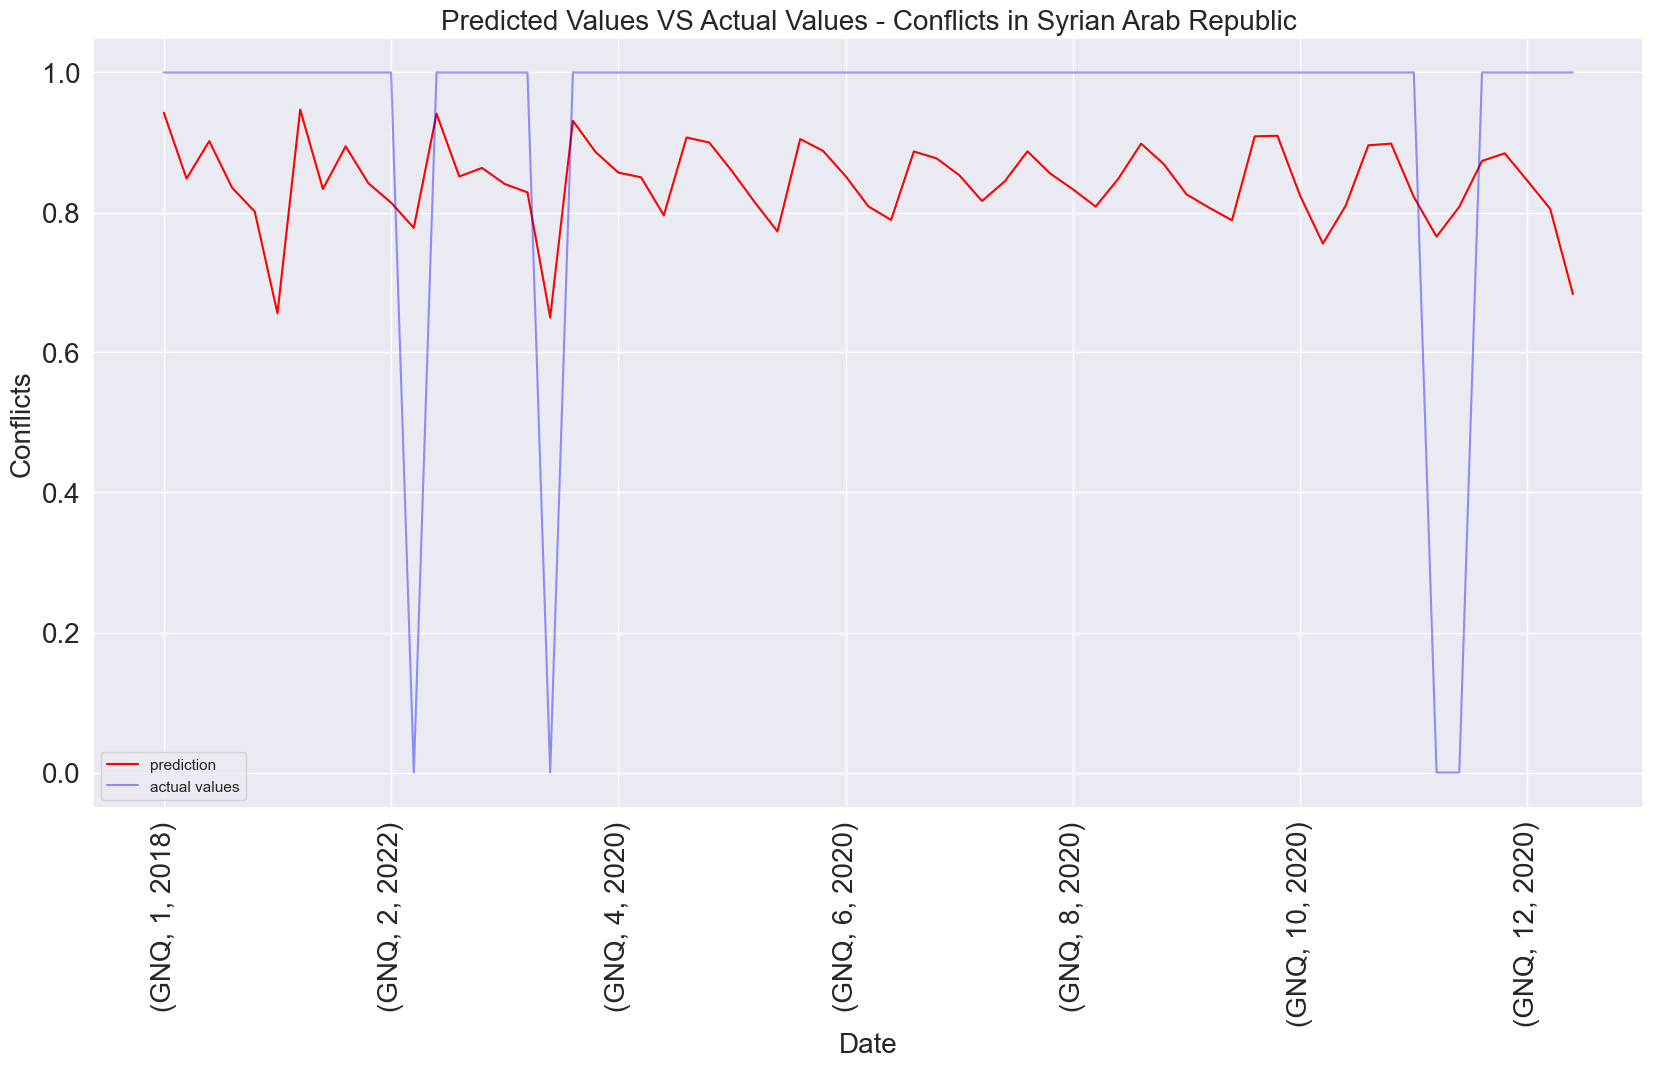

Epoch 1/30


2023-06-23 11:38:57.832213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-23 11:38:58.025292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/5 [=====>........................] - ETA: 4s - loss: 0.1560 - accuracy: 0.3400 - recall_15: 0.0000e+00

2023-06-23 11:38:58.389701: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 2s 125ms/step - loss: 0.2539 - accuracy: 0.4626 - recall_15: 0.3375
Epoch 2/30
5/5 [==============================] - 0s 54ms/step - loss: 0.2131 - accuracy: 0.4533 - recall_15: 0.9875
Epoch 3/30
5/5 [==============================] - 0s 37ms/step - loss: 0.2126 - accuracy: 0.3785 - recall_15: 1.0000
Epoch 4/30
5/5 [==============================] - 0s 36ms/step - loss: 0.2080 - accuracy: 0.3785 - recall_15: 1.0000
Epoch 5/30
5/5 [==============================] - 0s 27ms/step - loss: 0.1992 - accuracy: 0.4393 - recall_15: 0.9875
Epoch 6/30
5/5 [==============================] - 0s 22ms/step - loss: 0.1921 - accuracy: 0.5794 - recall_15: 0.9875
Epoch 7/30
5/5 [==============================] - 0s 13ms/step - loss: 0.1852 - accuracy: 0.6636 - recall_15: 0.9875
Epoch 8/30
5/5 [==============================] - 0s 18ms/step - loss: 0.1781 - accuracy: 0.6776 - recall_15: 0.9875
Epoch 9/30
5/5 [==============================] - 0s 17ms/step - loss: 0.1

2023-06-23 11:39:01.694477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-23 11:39:01.743160: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Mexico - Precision: 0.9365079365079365


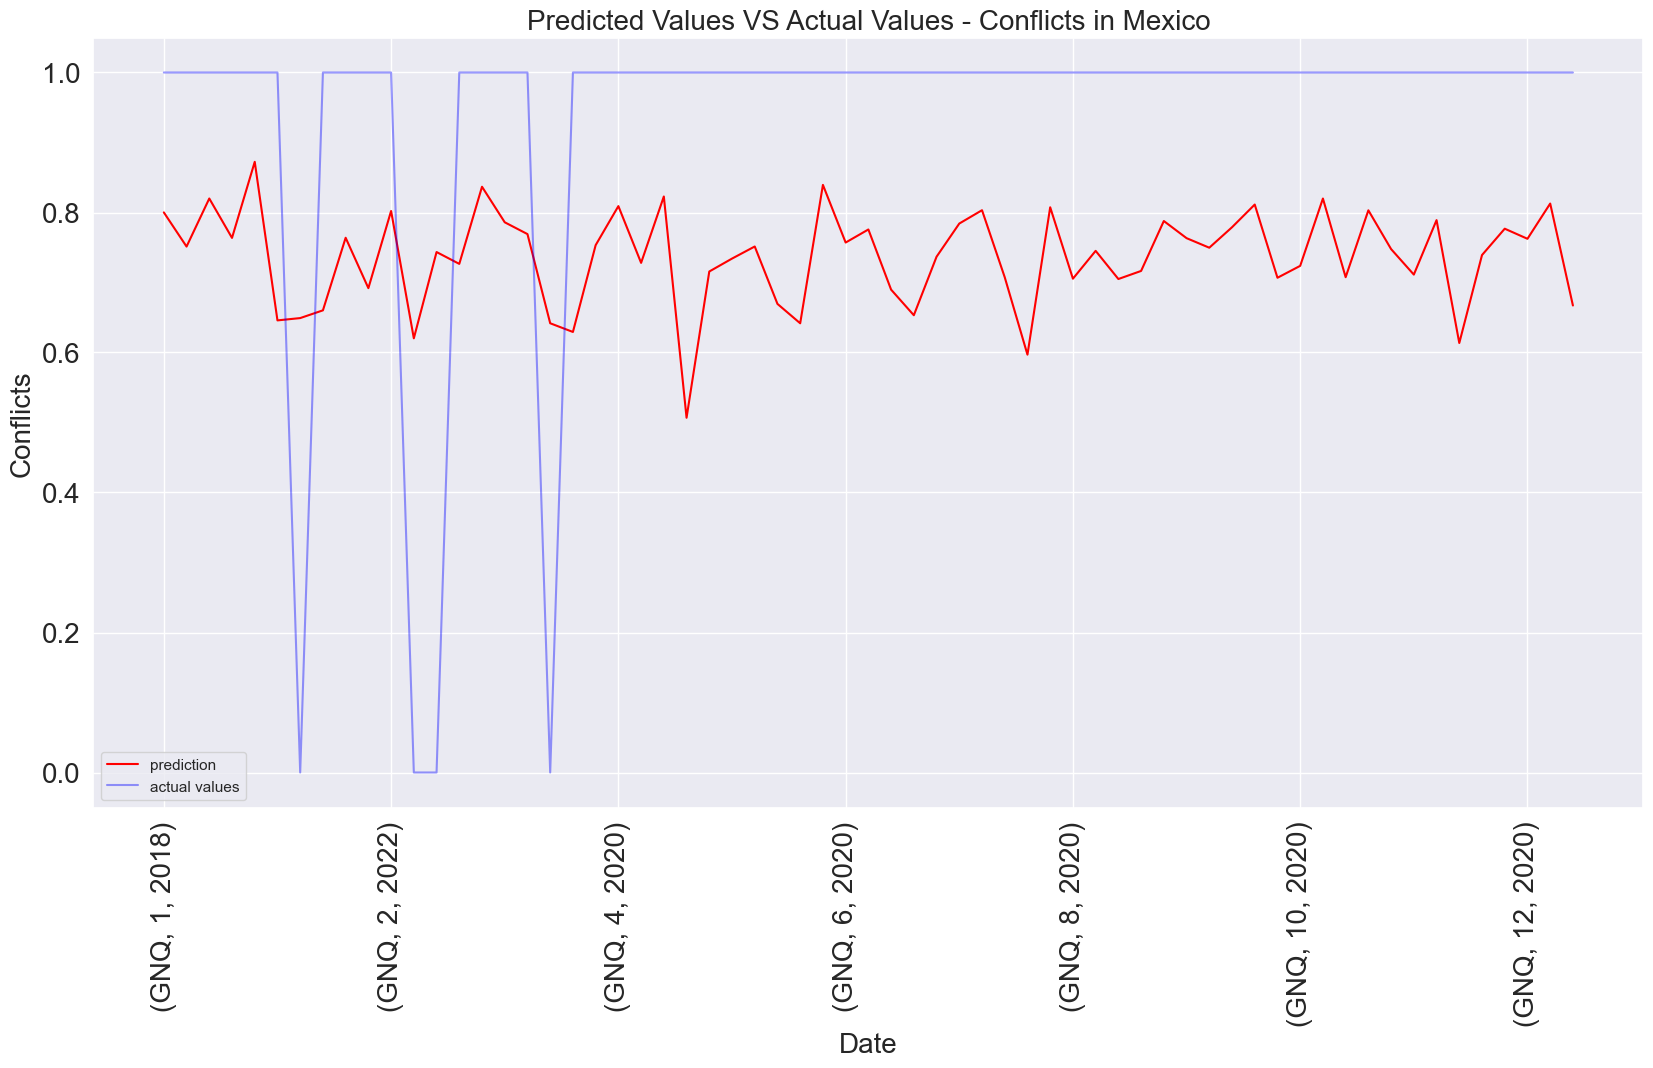

In [90]:
for i in range(len(top_10_country_names)): 
    # Obtain one country's data 
    country = armedconfdf[armedconfdf.country == top_10_country_names[i]]
        
    # Train test split, normalization and reshape the data
    x_train, x_test, y_train, y_test  = normalization_train_test_split(country)
    
    class_weights = compute_sample_weight(class_weight='balanced', y=y_train)

    # Create dictionary mapping classes to their weights
    class_weight_dict = dict(enumerate(class_weights))

# design network for conflicts 
    model = Sequential()
    model.add(LSTM(60, input_shape=(x_train.shape[1], x_train.shape[2])))  # Single LSTM layer with 60 neurons
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))  # Output layer

    loss = BinaryFocalLoss(gamma=2., pos_weight=3)  # Increase gamma for more focus on hard to classify instances
    model.compile(loss=loss, optimizer=Adam(learning_rate=0.001), metrics=['accuracy', metrics.Recall()])

    # fit network with class weights for handling imbalance
    history = model.fit(x_train, y_train, epochs=30, batch_size=50, class_weight=class_weight_dict, verbose=1, shuffle=False)  
    # make a prediction
   # make a prediction
    y_test_pre = model.predict(x_test)

# Trim y_test and X_test to match the length of y_test_pre
    y_test = y_test[:len(y_test_pre)]
    X_test = X_test[:len(y_test_pre)]


# Precision calculation
    precision = precision_score(y_test, [round(i[0]) for i in y_test_pre])
    print('{} - Precision: {}'.format(top_10_country_names[i], precision))

# Create new dataframe for plot 
    pa = pd.DataFrame()

# Adjust the date to match the length of y_test_pre
    # Adjust the date to match the length of y_test_pre
    pa['Date'] = list(X_test.index)[:len(y_test_pre)]
    pa['Prediction'] = [i[0] for i in y_test_pre]
    pa['Actual Values'] = y_test

    plt.figure(figsize=(20,10))
    pa.groupby('Date')['Prediction'].sum().plot(kind='line', label='prediction', color='red', alpha=1)
    pa.groupby("Date")['Actual Values'].sum().plot(kind='line', label='actual values', color='blue', alpha=0.4)
    plt.xticks(rotation=90,size=20)
    plt.yticks(size=20)

    plt.ylabel('Conflicts',fontsize=20)
    plt.xlabel('Date',fontsize=20)
    plt.title('Predicted Values VS Actual Values - Conflicts in {}'.format(top_10_country_names[i]),fontsize=20)
    plt.legend()
    plt.show()
